# Requisitos

### Bibliotecas

In [ ]:
!pip install numpy
!pip install keybert
!pip install -U scikit-learn
!pip install scikit-learn==0.24.2
!pip install nltk
!pip install rake-nltk
!pip install spacy
!python -m spacy download pt_core_news_md
!pip install gensim
!pip install rank_bm25
!pip install optuna
!pip install seaborn
!pip install kneed
!pip install pydot
!pip install itertools
!pip install networkx
!pip install hdbscan
!pip install pydotplus
!pip install xlsxwriter
!pip install langchain
!pip install -U langchain-community

  Using cached scikit-learn-0.24.2.tar.gz (7.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 19.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by s

In [ ]:
import pandas as pd
import pickle
import nltk
import os
import spacy
import numpy as np
import statistics
import seaborn as sns
import itertools
from pathlib import Path
import sys
from datetime import datetime
import joblib
import pydot
import random
import json
import re
import math
from collections import Counter
import time
import hdbscan
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
from sklearn import metrics
from sklearn.cluster import HDBSCAN, DBSCAN, KMeans, OPTICS, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from kneed import KneeLocator
import networkx as nx
from networkx.readwrite import json_graph
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from rank_bm25 import BM25Okapi
from rake_nltk import Rake
import optuna
from optuna.storages import RDBStorage
import graphviz
from graphviz import Source
from langchain.llms.ollama import Ollama

from google.colab import files
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### Modelos de Sentence Transformers

In [ ]:
nltk.download("stopwords")
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words("portuguese")

#Português
#MODEL_ML = "paraphrase-multilingual-MiniLM-L12-v2"
#MODEL_ML = "rufimelo/bert-large-portuguese-cased-sts"
#MODEL_ML = "PORTULAN/serafim-100m-portuguese-pt-sentence-encoder"
#MODEL_ML = "PORTULAN/serafim-900m-portuguese-pt-sentence-encoder"

#Inglês
MODEL_ML = "all-MiniLM-L6-v2"
#MODEL_ML ="all-mpnet-base-v2"
#MODEL_ML ="multi-qa-mpnet-base-cos-v1"
#MODEL_ML ="gtr-t5-base"
#MODEL_ML ="all-MiniLM-L12-v2"
#MODEL_ML ="gtr-t5-large"

# Todos
#MODELS_ML = [
#    "paraphrase-multilingual-MiniLM-L12-v2",
#    "rufimelo/bert-large-portuguese-cased-sts",
#    "PORTULAN/serafim-100m-portuguese-pt-sentence-encoder",
#    "PORTULAN/serafim-900m-portuguese-pt-sentence-encoder",
#    "all-MiniLM-L6-v2",
#    "all-mpnet-base-v2",
#    "multi-qa-mpnet-base-cos-v1",
#    "gtr-t5-base",
#    "all-MiniLM-L12-v2",
#    "gtr-t5-large"
#]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Parâmetros

In [ ]:
# Algoritmo
algorithm = "kmeans"
# algorithm = "hieraquico"
# algorithm = "dbscan"

# Labelling
labelling = "kbert"
# labelling = "verbs"
# labelling = "closest"
# labelling = "bm25"
# labelling = "rake"
#labelling = "llm"

# Datasets de treino
filename = "twitter_final_treino.xlsx"
#filename = "MultiWOZ_DAs_train.csv"

# Datasets de teste
filename_test = "twitter_final_teste.xlsx"
#filename_test = "MultiWOZ_DAs_test.csv"

# Métrica a otimizar
metric_to_optimize = "silhouette"
#metric_to_optimize = "vmeasure"
#metric_to_optimize = "NONE" #quando damos nós o número fixo de clusters para user e para sys

# Valores de Threshold
#threshold = [0, 0.05, 0.1, 0.15, 0.2]
threshold = [0.1]

# Beta V-measure
beta = 1

# Número de utterances passadas a considerar para o contexto (1 = sem contexto)
id_max = 1

# Número de trials para o optuna
n_trials = 5

# URL para o Ollama funcionar
llm_url = "http://localhost:8080"

In [ ]:
# Validation
val = {"validation":False, "val_filename":"twitter_final_treino.xlsx", "val_filename_test":"twitter_final_teste.xlsx", "val_model":"all-MiniLM-L6-v2"}

# Funções

### Formatação dos dados e vetorização

In [ ]:
def normalize_dataset(df_initial, regex=None, removeGreetings=None, speaker=None):
    """Normalize turn_id by (all turn_id's/max turn_id) and some column names."""
    df = df_initial.copy()

    # Padrões para substituição
    url_pattern = r"https?://\S+"
    url_placeholder = "xURLx"
    user_tags_pattern = "@\\S+"
    user_tags_placeholder = "xUSERNAMEx"

    #Renomear as colunas
    if "text" in df.columns:
        df.rename(columns={"text": "utterance"}, inplace=True)

    if "Utterance" in df.columns:
        df.rename(columns={"Utterance": "utterance"}, inplace=True)

    if "transcript" in df.columns:
        df.rename(columns={"transcript": "utterance"}, inplace=True)

    if "Msg" in df.columns:
        df.rename(columns={"Msg": "utterance"}, inplace=True)

    if "intent_title" in df.columns:
        df.rename(columns={"intent_title": "trueLabel"}, inplace=True)

    if "dialog_act" in df.columns:
        df.rename(columns={"dialog_act": "trueLabel"}, inplace=True)

    if "dialogue_act" in df.columns:
        df.rename(columns={"dialogue_act": "trueLabel"}, inplace=True)

    if "speaker" in df.columns:
        df.rename(columns={"speaker": "Speaker"}, inplace=True)

    if "user" in df.columns:
        df.rename(columns={"user": "Speaker"}, inplace=True)

    if "interlocutor" in df.columns:
        df.rename(columns={"interlocutor": "Speaker"}, inplace=True)

    if "trueLabel" in df.columns:
        df["trueLabel"] = df["trueLabel"].replace(" ", "_", regex=True)

    if 'trueLabel' in df.columns:
        df['utterance']= df['utterance'].apply(lambda x: x.lower())

    if 'trueLabel' in df.columns:
        df.trueLabel = df.trueLabel.fillna('none')

    # Substituição de padrões usando expressões regulares
    if regex is True:
        df["utterance"] = df["utterance"].replace(
            to_replace=url_pattern, value=url_placeholder, regex=True
        )
        df["utterance"] = df["utterance"].replace(
            to_replace=user_tags_pattern, value=user_tags_placeholder, regex=True
        )

    if speaker == "both":
        df = df

    if 'Speaker' in df.columns:
        df['Speaker'] = df['Speaker'].replace('USR', 'USER')
        df['Speaker'] = df['Speaker'].replace('Cliente', 'USER')
        df['Speaker'] = df['Speaker'].replace('SERVICE', 'SYSTEM')
        df['Speaker'] = df['Speaker'].replace('SYS', 'SYSTEM')
        df['Speaker'] = df['Speaker'].replace('Automaise', 'SYSTEM')

    df['Speaker'] = df['Speaker'].str.strip()

    # Criação de 'dialogue_id' com base no 'turn_id'
    if 'dialogue_id' not in df.columns and 'turn_id' in df.columns:
        dialog = 0
        result = []
        i_anterior = -1
        for i in df['turn_id']:
            if i_anterior == -1 or i > i_anterior:
                i_anterior = i
            else:
                dialog = dialog + 1
                i_anterior = -1
            result.append(dialog)
        df['dialogue_id'] = result

    # Criação de 'turn_id' com base no 'dialogue_id'
    if 'turn_id' not in df.columns and 'dialogue_id' in df.columns:
        df['turn_id'] = df.groupby('dialogue_id').cumcount()

    #create variable which is a incremental sequence by number of utterances
    df['sequence'] = [i for i in range(len(df))]

    return df


In [ ]:
def compute_weighted_mean(df, id_max=99999, sep=False, opt=1):
    df = df.sort_values(by=['dialogue_id', 'turn_id']).reset_index(drop=True)

    weighted_vectors = [None] * len(df)  # Initialize the list with None to maintain alignment

    if sep:
        grouped = df.groupby(['dialogue_id', 'Speaker'])
    else:
        grouped = df.groupby('dialogue_id')

    for name, group in grouped:
        sum_weighted_vectors = []

        for idx, row in group.iterrows():
            vector = row['vectors']
            if len(sum_weighted_vectors) >= id_max:
                sum_weighted_vectors.pop(0)
            sum_weighted_vectors.append(vector)

            sum_weights = range(1, len(sum_weighted_vectors) + 1)
            if opt == 2:
                weighted_mean_vector = np.concatenate(np.mean(sum_weighted_vectors[:-1], axis=0), sum_weighted_vectors[-1])
            else:
                weighted_mean_vector = sum(sum_weighted_vectors[g] * sum_weights[g] / sum(sum_weights) for g in range(len(sum_weighted_vectors)))
            weighted_vectors[idx] = weighted_mean_vector

    df['vectors_weight'] = weighted_vectors
    return df

In [ ]:
def use_sentence_transformer(sentences, model):
    # as frases são codificadas chamando model.encode()
    embeddings = model.encode(sentences)
    vectors = np.array(embeddings)
    return vectors

### Silhouette

In [ ]:
#Silhouette Score
def silhouette_method(data, min_k, max_k, incr):
    number_clusters = 0
    atual_silhouette = 0.000
    # Prepare the scaler
    scale = StandardScaler().fit(data)

    # Fit the scaler
    scaled_data = pd.DataFrame(scale.fit_transform(data))

    # Para o método de silhouette, k precisa começar a partir de 2
    n_clusters_axis = range(min_k, max_k, incr)
    silhouettes = []

    # Ajustar o modelo
    for k in n_clusters_axis:
        kmeans = KMeans(n_clusters=k, init="k-means++", random_state=2)
        kmeans.fit(scaled_data)
        score = metrics.silhouette_score(scaled_data, kmeans.labels_)
        silhouettes.append(score)
        if score > atual_silhouette:
            number_clusters = k
            atual_silhouette = score

    #Gerar o grafo de dispersão
    scatter_plot = sns.scatterplot(
        x=n_clusters_axis, y=silhouettes)

    #Usa a função get_figure e armazena o gráfico em uma variável (scatter_fig)
    scatter_fig = scatter_plot.get_figure()

    # Guarda o gráfico
    scatter_fig.savefig('scatterplot.png')

    return number_clusters

### Clustering s/Optuna

#### K-means

In [ ]:
# Função para treinar o modelo KMeans e guardar os resultados num arquivo pickle
def clustering_kmeans(vectors, n_clusters, nomeFichPickle, max_iters=2500):
    # Verifica se o modelo KMeans já foi treinado e guardado
    if not os.path.exists(nomeFichPickle):
        # Se o modelo ainda não foi treinado, executar o KMeans
        kmeans = KMeans(n_clusters=n_clusters, init="k-means++", max_iter=max_iters, random_state=2)
        kmeans.fit(vectors)

        # Obtém rótulos de cluster e centros de cluster
        labels_kmeans = kmeans.labels_
        centers_kmeans = kmeans.cluster_centers_

        # Imprime métricas de avaliação interna para KMeans
        print("\nInternal Evaluation:\nSilhouette Score: ", metrics.silhouette_score(vectors, labels_kmeans))
        print("Davies-Bouldin Index (DBI): ", metrics.davies_bouldin_score(vectors, labels_kmeans))

        # Guarda o modelo KMeans treinado num ficheiro pickle
        with open(nomeFichPickle, 'wb') as file:
            pickle.dump((labels_kmeans, centers_kmeans), file)
    else:
        # Se o modelo já foi treinado e salvo, carrega-o do arquivo pickle
        with open(nomeFichPickle, 'rb') as file:
            labels_kmeans, centers_kmeans = pickle.load(file)

    return labels_kmeans, centers_kmeans


### Clustering Optuna

#### K-means

##### Silhouette

In [ ]:
#CLUSTERING -> K-MEANS
def objective_kmeans_silhouette(trial, vectors):
    #model_name = trial.suggest_categorical('model_name', MODELS_ML)
    #model_ml = SentenceTransformer(model_name)

    # Codifica as frases usando o modelo selecionado
    #vectors = use_sentence_transformer(utterances, model_ml)

    n_clusters = trial.suggest_int('n_clusters', 3, 10)
    init_method = trial.suggest_categorical('init_method', ['k-means++', 'random'])
    n_init = trial.suggest_int('n_init', 1, 30)
    tol = trial.suggest_float('tol', 1e-4, 1e-1, log=True)
    algorithm = trial.suggest_categorical('algorithm', ['lloyd', 'elkan'])

    kmeans = KMeans(
        n_clusters=n_clusters,
        init=init_method,
        n_init=n_init,
        tol=tol,
        algorithm=algorithm,
        random_state=2
    )
    kmeans.fit(vectors)

    silhouette = metrics.silhouette_score(vectors, kmeans.labels_)
    return silhouette


def clustering_kmeans_silhouette_optuna(vectors, role, metric, nomeFichPickle):
    labels_kmeans = None
    centers_kmeans = None
    silhouette_kmeans = None
    n_clusters = None
    best_params = None
    parameters_trial = None
    study = None

    # Configurar a base de dados para armazenar trials
    storage_path = "sqlite:///optuna_studies.db"
    storage = RDBStorage(storage_path)

    # Se o modelo já foi treinado e salvo, carrega-o do ficheiro pickle
    if os.path.exists(nomeFichPickle):
        with open(nomeFichPickle, 'rb') as file:
            kmeans = pickle.load(file)
            print("kmeans", kmeans)
            # labels_kmeans = kmeans['labels']
            labels_kmeans, centers_kmeans = kmeans.labels_, kmeans.cluster_centers_
            params = kmeans.get_params()
        silhouette_kmeans = metrics.silhouette_score(vectors, labels_kmeans)
        print(f"Modelo já existente para {role}. Carregando os resultados salvos.")
        print(f"Hiperparâmetros carregados do pickle para {role}: {params}")
        print(f"Melhor {metric} Score carregado do pickle para {role}: {silhouette_kmeans}")

        if params is not None:
            n_clusters = params["n_clusters"]
    else:
        # Se o ficheiro pickle não existe, aplica o optuna
        study_name = f"study_{role}"
        study = optuna.create_study(
            study_name=study_name,
            storage=storage,
            load_if_exists=True,
            direction="maximize",
        )

        study.optimize(lambda trial: objective_kmeans_silhouette(trial, vectors), n_trials=n_trials)
        best_trial = study.best_trial  # Obtém a melhor tentativa

        best_params = best_trial.params
        #model_name = best_params['model_name']
        #model_ml = SentenceTransformer(model_name)
        #vectors = use_sentence_transformer(utterances, model_ml)
        n_clusters = best_params['n_clusters']
        init = best_params['init_method']
        n_init = best_params['n_init']
        tol = best_params['tol']
        algorithm = best_params['algorithm']

        parameters_trial = {
            'n_clusters': n_clusters,
            'init_method': init,
            'n_init': n_init,
            'tol': tol,
            'algorithm': algorithm
        }

        kmeans = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, tol=tol, algorithm=algorithm, random_state=2)
        kmeans.fit(vectors)

        silhouette_kmeans = metrics.silhouette_score(vectors, kmeans.labels_)

        # Guarda todos os resultados no arquivo pickle
        with open(nomeFichPickle, 'wb') as file:
            pickle.dump(kmeans, file)

        print(f"Melhores parâmetros encontrados para {role} na Função Silhouette:")
        print(best_params)
        print(f"Melhor Silhouette para {role}: {silhouette_kmeans}")

        labels_kmeans, centers_kmeans = kmeans.labels_, kmeans.cluster_centers_

    return labels_kmeans, centers_kmeans, silhouette_kmeans, n_clusters, study

##### V-measure

In [ ]:
#PARA DIALOGUE ACTS
def objective_kmeans_vmeasure(trial, vectors, normalized_df):
    # Defino os parâmetros do KMeans a serem otimizados
    n_clusters = trial.suggest_int('n_clusters', 3, 10)
    init_method = trial.suggest_categorical('init_method', ['k-means++', 'random'])
    n_init = trial.suggest_int('n_init', 1, 30)
    tol = trial.suggest_float('tol', 1e-4, 1e-1, log=True)
    algorithm = trial.suggest_categorical('algorithm', ['lloyd', 'elkan'])

    # Configurar kmeans
    kmeans = KMeans(
        n_clusters=n_clusters,
        init=init_method,
        n_init=n_init,
        max_iter=1000,
        tol=tol,
        algorithm=algorithm,
        random_state=2
    )
    kmeans.fit(vectors)

    if 'trueLabel' in normalized_df.columns:
        true_labels = []
        pred_labels = []

        for idx in range(len(kmeans.labels_)):
            # Obter o valor da coluna trueLabel para o índice idx
            true_label_entry = normalized_df.iloc[idx]['trueLabel']

            # Verificar se true_label_entry é uma string válida
            if isinstance(true_label_entry, str):
                utterance_true_labels = true_label_entry.split(',')
            else:
                raise ValueError(f"O 'trueLabel' na linha {idx} não está no formato esperado.")

            cluster_label = kmeans.labels_[idx]

            true_labels.extend(utterance_true_labels)
            pred_labels.extend([cluster_label] * len(utterance_true_labels))

        # Calcular as métricas
        v_measure = metrics.v_measure_score(true_labels, pred_labels, beta=1.0)
        silhouette_score = metrics.silhouette_score(vectors, kmeans.labels_)
        adjusted_rand_score = metrics.adjusted_rand_score(true_labels, pred_labels)
        completeness_score = metrics.completeness_score(true_labels, pred_labels)
        homogeneity_score = metrics.homogeneity_score(true_labels, pred_labels)
        calinski_harabasz_score = metrics.calinski_harabasz_score(vectors, kmeans.labels_)
        davies_bouldin_score = metrics.davies_bouldin_score(vectors, kmeans.labels_)

        # Adicionar os valores calculados aos atributos do trial
        trial.set_user_attr(key='v_measure', value=float(v_measure))
        trial.set_user_attr(key='silhouette_score', value=float(silhouette_score))
        trial.set_user_attr(key='adjusted_rand_score', value=float(adjusted_rand_score))
        trial.set_user_attr(key='completeness_score', value=float(completeness_score))
        trial.set_user_attr(key='homogeneity_score', value=float(homogeneity_score))
        trial.set_user_attr(key='calinski_harabasz_score', value=float(calinski_harabasz_score))
        trial.set_user_attr(key='davies_bouldin_score', value=float(davies_bouldin_score))

        print(f"Trial {trial.number}:")
        #print(f"  Model Name: {model_name}")
        print(f"  Silhouette Score: {silhouette_score}")
        print(f"  V-Measure: {v_measure}")
        print(f"  Adjusted Rand Score: {adjusted_rand_score}")
        print(f"  Completeness Score: {completeness_score}")
        print(f"  Homogeneity Score: {homogeneity_score}")
        print(f"  Calinski-Harabasz Score: {calinski_harabasz_score}")
        print(f"  Davies-Bouldin Score: {davies_bouldin_score}")

        return v_measure
    else:
        silhouette_score = metrics.silhouette_score(vectors, kmeans.labels_)
        print("Como o dataset não está anotado, não é possível calcular a V-measure e foi retornada a Silhouette score.")
        return silhouette_score


def clustering_kmeans_vmeasure_optuna(vectors, normalized_df, role, nomeFichPickle, val={}):
    labels_kmeans = None
    centers_kmeans = None
    n_clusters = None
    study = None
    # Configurar a base de dados para armazenar trials
    storage_path = "sqlite:///optuna_studies.db"
    storage = RDBStorage(storage_path)

    # Se o ficheiro pickle não existe, aplicar o optuna
    # Se for para validar configurações de um dataset diferente
    if val["validation"]:
        # Colocar path do melhor modelo
        best_model_path = f'models/{val["val_model"]}/{val["val_filename"]}/vmeasure/kmeans_{role}.pkl'
        with open(best_model_path, 'rb') as file:
            kmeans = pickle.load(file)
            labels_kmeans, centers_kmeans = kmeans.labels_, kmeans.cluster_centers_

        best_params = kmeans.get_params()
        n_clusters = best_params['n_clusters']
        #max_iters = best_params['max_iters']
        init = best_params['init']
        n_init = best_params['n_init']
        tol = best_params['tol']
        algorithm= best_params['algorithm']

        kmeans = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, tol=tol, algorithm=algorithm, random_state=2)

        kmeans.fit(vectors)

        silhouette_kmeans = metrics.silhouette_score(vectors, kmeans.labels_)

        with open(nomeFichPickle, 'wb') as file:
            pickle.dump(kmeans, file)

        print(f"Melhores parâmetros encontrados para {role}:")
        print(best_params)
        print(f"Melhor Silhouette para {role}: {silhouette_kmeans}")
        print(f"Modelo já existente para {role}. Carregando os resultados salvos.")
        labels_kmeans, centers_kmeans = kmeans.labels_, kmeans.cluster_centers_
    elif os.path.exists(nomeFichPickle):
        with open(nomeFichPickle, 'rb') as file:
            kmeans = pickle.load(file)
            print("kmeans", kmeans)
            # labels_kmeans = kmeans['labels']
            labels_kmeans, centers_kmeans = kmeans.labels_, kmeans.cluster_centers_
        print(f"Modelo já existente para {role}. Carregando os resultados salvos.")
    else:
        study_name = f"study_{role}"
        study = optuna.create_study(
            study_name=study_name,
            storage=storage,
            load_if_exists=True,
            direction="maximize",
        )

        study.optimize(lambda trial: objective_kmeans_vmeasure(trial, vectors, normalized_df), n_trials=n_trials)

        best_trial = study.best_trial
        best_params = best_trial.params
        #model_name = best_params['model_name']
        #model_ml = SentenceTransformer(model_name)
        #vectors = use_sentence_transformer(utterances, model_ml)
        n_clusters = best_params['n_clusters']
        init = best_params['init_method']
        n_init = best_params['n_init']
        tol = best_params['tol']
        algorithm = best_params['algorithm']

        parameters_trial = {
            'n_clusters': n_clusters,
            'init_method': init,
            'n_init': n_init,
            'tol': tol,
            'algorithm': algorithm
        }

        kmeans = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, tol=tol, algorithm=algorithm, random_state=2)
        kmeans.fit(vectors)

        print(f"Melhores parâmetros encontrados para {role} na Otimização da V-measure:")
        print(best_params)

        with open(nomeFichPickle, 'wb') as file:
            pickle.dump(kmeans, file)

        labels_kmeans, centers_kmeans = kmeans.labels_, kmeans.cluster_centers_

    return labels_kmeans, centers_kmeans, n_clusters, study

##### Outra métrica

In [ ]:
#CLUSTERING -> K-MEANS
def objective_kmeans_nova_func(trial, vectors, n_clusters_ant, best_silhouette):
    n_clusters_ideal = 5
    n_clusters = trial.suggest_int('n_clusters', 3, 10)
    init_method = trial.suggest_categorical('init_method', ['k-means++', 'random'])
    n_init = trial.suggest_int('n_init', 1, 30)
    tol = trial.suggest_float('tol', 1e-4, 1e-1, log=True)
    algorithm = trial.suggest_categorical('algorithm', ['lloyd', 'elkan'])
    print("n_clusters 1", n_clusters)

    kmeans = KMeans(
        n_clusters=n_clusters,
        init=init_method,
        n_init=n_init,
        tol=tol,
        algorithm=algorithm,
        random_state=2
    )
    kmeans.fit(vectors)

    # Se o num de clusters que vem da função objetivo da silhouette for igual ao num de clusters ideal (5), passamos o num de clusters ideal para 6
    objective_value = best_silhouette - (math.log(1 + (abs(n_clusters_ant - n_clusters_ideal))) / n_clusters_ideal)

    return objective_value

def clustering_kmeans_nova_func_optuna(vectors, role, metric, nomeFichPickle, n_clusters_ant, best_silhouette):
    labels_kmeans = None
    centers_kmeans = None
    silhouette_kmeans = None
    n_clusters = None
    best_params = None
    parameters_trial = None

    # Se o modelo já foi treinado e guardado, carrega-o do ficheiro pickle
    if os.path.exists(nomeFichPickle):
        with open(nomeFichPickle, 'rb') as file:
            data = pickle.load(file)
            labels_kmeans, centers_kmeans, params, silhouette_kmeans = data.get('labels'), data.get('centers'), data.get('params'), data.get('silhouette')
        print(f"Modelo já existente para {role}. Carregando os resultados salvos.")
        print(f"Hiperparâmetros carregados do pickle para {role}: {params}")
        print(f"Melhor Silhouette Score carregado do pickle para {role}: {silhouette_kmeans}")

    else:
        # Se o ficheiro pickle não existe, aplica o optuna
        study = optuna.create_study(direction="maximize")  # Queremos o melhor valor
        objective_func = lambda trial: objective_kmeans_nova_func(trial, vectors, n_clusters_ant, best_silhouette)
        study.optimize(objective_func, n_trials=1)

        best_trial = study.best_trial  # Obtém a melhor tentativa

        best_params = best_trial.params
        n_clusters = best_params['n_clusters']
        init = best_params['init_method']
        n_init = best_params['n_init']
        tol = best_params['tol']
        algorithm = best_params['algorithm']

        kmeans = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, tol=tol, algorithm=algorithm, random_state=2)
        kmeans.fit(vectors)

        silhouette_kmeans = metrics.silhouette_score(vectors, kmeans.labels_)

        with open(nomeFichPickle, 'wb') as file:
            pickle.dump({'labels': kmeans.labels_, 'centers': centers_kmeans, 'params': best_params,'silhouette': silhouette_kmeans}, file)

        print(f"Melhores parâmetros encontrados para {role} na Nova Função de Maximização:")
        print(best_params)
        print(f"Nova Silhouette para {role}: {silhouette_kmeans}")

        labels_kmeans, centers_kmeans = kmeans.labels_, kmeans.cluster_centers_

    return labels_kmeans, centers_kmeans, silhouette_kmeans, n_clusters, best_params


#### HIERÁRQUICO

In [ ]:
#CLUSTERING -> HIERÁRQUICO
def objective_hierarquico_silhouette(trial, vectors):
    n_clusters = trial.suggest_int('n_clusters', 2, 20)
    linkage_method = trial.suggest_categorical('linkage', ['ward', 'complete', 'average', 'single'])

    if linkage_method == 'ward':
        metric = 'euclidean'  # Se a linkage for 'ward', a métrica é sempre 'euclidean'
    else:
        metric = trial.suggest_categorical('metric', ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'])

    hierarchical = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage=linkage_method,
        metric=metric
    )
    hierarchical.fit(vectors)

    silhouette = metrics.silhouette_score(vectors, hierarchical.labels_)
    return silhouette


# Função de clustering Hierárquico com Optuna
def clustering_hierarquico_silhouette_optuna(vectors, role, nomeFichPickle):
    labels_hierarchical = None
    study = None
    silhouette_hierarquico = None
    n_clusters = None

    # Se o modelo já foi treinado e salvo, carrega-o do ficheiro pickle
    if os.path.exists(nomeFichPickle):
        with open(nomeFichPickle, 'rb') as file:
            data = pickle.load(file)
            labels_hierarchical, params, silhouette_hierarquico = data.get('labels'), data.get('params'), data.get('silhouette')
        print(f"Modelo já existente para {role}. Carregando os resultados guardados.")
        print(f"Hiperparâmetros carregados do pickle para {role}: {params}")
        print(f"Melhor Silhouette Score carregado do pickle para {role}: {silhouette_hierarquico}")
    else:
        # Se o ficheiro pickle não existe, aplica o optuna
        # Garante que é executado até que os resultados estejam disponíveis
        while labels_hierarchical is None:
            study = optuna.create_study(direction="maximize")

            objective_func = lambda trial: objective_hierarquico_silhouette(trial, vectors)
            study.optimize(objective_func, n_trials=5)

            best_params = study.best_params
            n_clusters = best_params['n_clusters']
            linkage_method = best_params['linkage']

            hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
            hierarchical.fit(vectors)
            silhouette_hierarquico = metrics.silhouette_score(vectors, hierarchical.labels_)

            with open(nomeFichPickle, 'wb') as file:
                pickle.dump({'labels': hierarchical.labels_, 'params': best_params,'silhouette': silhouette_hierarquico}, file)

            print(f"Melhores parâmetros encontrados para {role} na Função Silhouette:")
            print(best_params)
            print(f"Melhor Silhouette para {role}: {silhouette_hierarquico}")

            labels_hierarchical = hierarchical.labels_

    return labels_hierarchical, silhouette_hierarquico, n_clusters

##### Outra métrica

In [ ]:
#CLUSTERING -> HIERÁRQUICO
def objective_hierarquico_nova_func(trial, vectors, n_clusters_ant, best_silhouette):
    n_clusters_ideal = 5
    n_clusters = trial.suggest_int('n_clusters', 2, 20)
    linkage_method = trial.suggest_categorical('linkage', ['ward', 'complete', 'average', 'single'])

    if linkage_method == 'ward':
        metric = 'euclidean'  # Se a linkage for 'ward', a métrica é sempre 'euclidean'
    else:
        metric = trial.suggest_categorical('metric', ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'])

    hierarchical = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage=linkage_method,
        metric=metric
    )
    hierarchical.fit(vectors)

    objective_value = best_silhouette - (math.log(1 + (abs(n_clusters_ant - n_clusters_ideal))) / n_clusters_ideal)

    return objective_value

def clustering_hierarquico_nova_func_optuna(vectors, role, nomeFichPickle, n_clusters_ant, best_silhouette):
    labels_hierarchical = None
    study = None

    # Se o modelo já foi treinado e salvo, carrega-o do ficheiro pickle
    if os.path.exists(nomeFichPickle):
        with open(nomeFichPickle, 'rb') as file:
            data = pickle.load(file)
            labels_hierarchical, params, silhouette_hierarquico = data.get('labels'), data.get('params'), data.get('silhouette')
            print(f"Modelo já existente para {role}. Carregando os resultados guardados.")
            print(f"Hiperparâmetros carregados do pickle para {role}: {params}")
            print(f"Melhor Silhouette Score carregado do pickle para {role}: {silhouette_hierarquico}")
    else:
        # Se o ficheiro pickle não existe, aplica o optuna
        # Garante que é executado até que os resultados estejam disponíveis
        while labels_hierarchical is None:
            study = optuna.create_study(direction="maximize")

            objective_func = lambda trial: objective_hierarquico_nova_func(trial, vectors, n_clusters_ant, best_silhouette)
            study.optimize(objective_func, n_trials=1)

            best_params = study.best_params
            n_clusters = best_params['n_clusters']
            linkage_method = best_params['linkage']

            hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
            labels_hierarchical = hierarchical.fit_predict(vectors)
            silhouette_hierarquico = metrics.silhouette_score(vectors, labels_hierarchical)

            with open(nomeFichPickle, 'wb') as file:
                pickle.dump({'labels': labels_hierarchical, 'params': best_params, 'silhouette': silhouette_hierarquico}, file)

            print(f"Melhores parâmetros encontrados para {role} na Nova Função de Maximização:")
            print(best_params)
            print(f"Nova Silhouette para {role}: {silhouette_hierarquico}")

    return labels_hierarchical, silhouette_hierarquico

#### DBSCAN

##### Silhouette

In [ ]:
#CLUSTERING -> DBSCAN
def objective_dbscan_silhouette(trial, vectors):
    eps = trial.suggest_float('eps', 0.1, 1.0)
    min_samples = trial.suggest_int('min_samples', 3, 100)
    metric = trial.suggest_categorical('metric', ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 10, 50)

    if algorithm == 'ball_tree' or algorithm == 'kd_tree' and metric == 'cosine':
        # Se o algoritmo for ball_tree ou kd_tree, a métrica não pode ser cosine
        metric = 'euclidean'

    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=algorithm, leaf_size=leaf_size)
    dbscan.fit(vectors)

    try:
        silhouette = metrics.silhouette_score(vectors, dbscan.labels_)
    except ValueError:
        silhouette = -1.0

    return silhouette

def clustering_dbscan_silhouette_optuna(vectors, nomeFichPickle, role="None"):
    labels_dbscan = None
    study_dbscan = None
    silhouette_dbscan = None
    n_clusters = None
    # Se o modelo já foi treinado e guardado, carrega-o do ficheiro pickle
    if os.path.exists(nomeFichPickle):
        # Se o modelo já foi treinado e salvo, carrega-o do ficheiro pickle
        with open(nomeFichPickle, 'rb') as file:
            dbscan = pickle.load(file)
            params = dbscan.get_params()
        silhouette = metrics.silhouette_score(vectors, dbscan.labels_)
        print(f"Modelo já existente para {role}. Carregando os resultados guardados.")
        print(f"Hiperparâmetros carregados do pickle para {role}: {params}")
        print(f"Melhor Silhouette Score carregado do pickle para {role}: {silhouette_dbscan}")
    else:
        # Se o ficheiro pickle não existe, aplica o optuna
        # Garante que é executado até que os resultados estejam disponíveis
        study_dbscan = optuna.create_study(direction='maximize')

        objective_func = lambda trial: objective_dbscan_silhouette(trial, vectors)
        study_dbscan.optimize(objective_func, n_trials=n_trials)

        best_params = study_dbscan.best_params
        eps = best_params['eps']
        min_samples = best_params['min_samples']
        metric = best_params['metric']
        algorithm = best_params['algorithm']
        leaf_size = best_params['leaf_size']

        if algorithm == 'ball_tree' or algorithm == 'kd_tree' and metric == 'cosine':
            # Se o algoritmo for ball_tree, a métrica não pode ser cosine
            metric = 'euclidean'

        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=algorithm, leaf_size=leaf_size)
        dbscan.fit(vectors)
        silhouette_dbscan = metrics.silhouette_score(vectors, dbscan.labels_)

        with open(nomeFichPickle, 'wb') as file:
            pickle.dump(dbscan, file)

        print(f"Melhores parâmetros encontrados para {role} na Função Silhouette:")
        print(best_params)
        print(f"Melhor Silhouette para {role}: {silhouette_dbscan}")

    labels_dbscan = dbscan.labels_
    n_clusters = len(set(labels_dbscan))

    return labels_dbscan, silhouette_dbscan, n_clusters, study_dbscan

##### V-measure

In [ ]:
def objective_dbscan_vmeasure(trial, vectors, normalized_df):

    eps = trial.suggest_float('eps', 0.1, 1.0)
    min_samples = trial.suggest_int('min_samples', 20, 100)
    metric = trial.suggest_categorical('metric', ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 10, 50)

    if algorithm == 'ball_tree' or algorithm == 'kd_tree' and metric == 'cosine':
        # Se o algoritmo for ball_tree ou kd_tree, a métrica não pode ser cosine
        metric = 'euclidean'

    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=algorithm, leaf_size=leaf_size)
    dbscan.fit(vectors)

    normalized_df = normalized_df.assign(cluster_label=dbscan.labels_)

    try:
        v_measure = metrics.v_measure_score(normalized_df['trueLabel'], normalized_df['cluster_label'], beta=1)
    except ValueError:
        silhouette = -20.0

    return v_measure

# @title
# Função para treinar o modelo DBSCAN e salvar os resultados em um arquivo pickle
def clustering_dbscan_vmeasure_optuna(vectors, nomeFichPickle, normalized_df, role="None"):
    """Receive vectors and do the clustering in DBSCAN (-1 cluster represents outliers)."""
    labels_dbscan = None
    study_dbscan = None
    n_clusters = None
    if not os.path.exists(nomeFichPickle):
        # minsamples, epsilons = get_hyperparameters_dbscan(vectors)
        # best_parameters = get_params_scores(vectors, minsamples, epsilons, pred_n_clusters, nomeFichParam)
        # dbscan = DBSCAN(eps=best_parameters[0], min_samples=best_parameters[1])

        study_dbscan = optuna.create_study(direction="maximize")  # Queremos o melhor silhouette
        objective_func = lambda trial: objective_dbscan_vmeasure(trial, vectors, normalized_df)
        study_dbscan.optimize(objective_func, n_trials=n_trials, gc_after_trial=True)

        best_trial = study_dbscan.best_trial  # Obtém a melhor tentativa
        print(best_trial)

        best_params = best_trial.params

        eps=best_params['eps']
        min_samples=best_params['min_samples']
        metric=best_params['metric']

        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        dbscan.fit(vectors)

        print(f"Melhores parâmetros encontrados para {role}:")
        print(best_params)

        # Save the model to a file
        with open(nomeFichPickle, 'wb') as f:
            pickle.dump(dbscan, f)
            f.close()
    else:
        # Se o modelo já foi treinado e salvo, carrega-o do ficheiro pickle
        with open(nomeFichPickle, 'rb') as file:
            dbscan = pickle.load(file)
        print(f"\nModelo já existente para {role}. Carregando os resultados salvos.")

    labels_dbscan = dbscan.labels_
    n_clusters = len(set(labels_dbscan))
    return labels_dbscan, n_clusters, study_dbscan

##### Outra métrica

In [ ]:
#CLUSTERING -> DBSCAN
def objective_dbscan_nova_func(trial, vectors, n_clusters_ant, best_silhouette):
    n_clusters_ideal = 5
    n_clusters_ant = n_clusters_ant if n_clusters_ant else 6  # Se n_clusters_ant é None, use 6 como valor padrão

    eps = trial.suggest_float('eps', 0.1, 1.0)
    min_samples = trial.suggest_int('min_samples', 20, 100)
    metric = trial.suggest_categorical('metric', ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 10, 50)

    if algorithm == 'ball_tree' or algorithm == 'kd_tree' and metric == 'cosine':
        # Se o algoritmo for ball_tree ou kd_tree, a métrica não pode ser cosine
        metric = 'euclidean'

    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=algorithm, leaf_size=leaf_size)
    dbscan.fit(vectors)

    objective_value = best_silhouette - (math.log(1 + (abs(n_clusters_ant - n_clusters_ideal))) / n_clusters_ideal)

    return objective_value


def clustering_dbscan_nova_func_optuna(vectors, role, nomeFichPickle, n_clusters_ant, best_silhouette):
    labels_dbscan = None
    study_dbscan = None

    # Se o modelo já foi treinado e guardado, carrega-o do ficheiro pickle
    if os.path.exists(nomeFichPickle):
        with open(nomeFichPickle, 'rb') as file:
            data = pickle.load(file)
            labels_dbscan, params, silhouette_dbscan = data.get('labels'), data.get('params'), data.get('silhouette')
        print(f"Modelo já existente para {role}. Carregando os resultados guardados.")
        print(f"Hiperparâmetros carregados do pickle para {role}: {params}")
        print(f"Melhor Silhouette Score carregado do pickle para {role}: {silhouette_dbscan}")
    else:
        # Se o ficheiro pickle não existe, aplica o optuna
        # Garante que é executado até que os resultados estejam disponíveis
        while labels_dbscan is None:
            study_dbscan = optuna.create_study(direction='maximize')

            objective_func = lambda trial: objective_dbscan_nova_func(trial, vectors, n_clusters_ant, best_silhouette)
            study_dbscan.optimize(objective_func, n_trials=n_trials)

            # Obtém os melhores parâmetros sugeridos pelo Optuna
            best_params = study_dbscan.best_params
            eps = best_params['eps']
            min_samples = best_params['min_samples']
            metric = best_params['metric']
            algorithm = best_params['algorithm']
            leaf_size = best_params['leaf_size']

            if algorithm == 'ball_tree' or algorithm == 'kd_tree' and metric == 'cosine':
                # Se o algoritmo for ball_tree, a métrica não pode ser cosine
                metric = 'euclidean'

            # Treina o modelo de clustering DBSCAN com os melhores parâmetros encontrados
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=algorithm, leaf_size=leaf_size)
            labels_dbscan = dbscan.fit_predict(vectors)

            # Verifica se o número de clusters é maior que 1
            if len(np.unique(labels_dbscan)) > 1:
                silhouette_dbscan = metrics.silhouette_score(vectors, labels_dbscan)
            else:
                # Se o número de clusters for 1, atribui rótulos padrão
                labels_dbscan = np.zeros_like(labels_dbscan)
                silhouette_dbscan = -1  #

            with open(nomeFichPickle, 'wb') as file:
                pickle.dump(dbscan, file)

            print(f"Melhores parâmetros encontrados para {role} na Nova Função de Maximização:")
            print(best_params)
            print(f"Nova Silhouette para {role}: {silhouette_dbscan}")

    return labels_dbscan, silhouette_dbscan

##### Predict

In [ ]:
# Igual ao kmeans.predict mas para o dbscan
def dbscan_predict(vectors, dbscan_model, new_data):
    y_new = np.ones(shape=len(new_data), dtype=int)*-1

    neigh = NearestNeighbors(n_neighbors=1).fit(vectors[dbscan_model.core_sample_indices_])
    (distances, indices) = neigh.kneighbors(new_data)
    for i, dist  in enumerate(distances):
        if dist < dbscan_model.eps:
            y_new[i] = dbscan_model.labels_[indices[i]]

    return y_new


### Labelling

#### KeyBERT

In [ ]:
def describe_clusters_kBERT(n_clusters, y_predicted, normalized_df, model, stopwords, n_grams, n_entries):
    # Inicializa o modelo KeyBERT
    kw_model = KeyBERT(model=model)

    # Cria um DataFrame vazio para armazenar as labels do cluster e palavras-chave do kBERT
    df_teste = normalized_df.copy()
    df_teste["predicted"] = y_predicted
    df_teste["utterance"] = df_teste["utterance"].astype(str)

    # Lista para armazenar as labels do cluster e palavras-chave do kBERT
    list_kBERT = []
    list_clusters = []  # clusters

    # ids dos clusters, por ordem crescente
    cluster_ids = sorted(list(set(y_predicted)))

    # Percorre os clusters
    for cluster_id in range(n_clusters):
        predicted_df = df_teste[df_teste["predicted"] == cluster_id]
        corpus = predicted_df['utterance']

        corpus = [str(c) for c in corpus]
        #print(corpus)

        # Extrai palavras-chave - KeyBERT
        keywords = kw_model.extract_keywords(" ".join(corpus), keyphrase_ngram_range=(1, n_grams), stop_words=stopwords, highlight=False, top_n=n_entries)
        #print("keywords", keywords)

        # Remove duplicatas das palavras-chave
        keywords_list = [w[0] for w in keywords]
        keywords_set = set(keywords_list)
        keywords_list = list(keywords_set)

        # Adiciona "Outros {cluster_id}" se a lista de palavras-chave estiver vazia
        if not keywords:
            keywords = [(f"Outros {cluster_id}", 1.0)]

        print(f"Cluster {cluster_id} - Keywords: {keywords}")

        # Armazena apenas as palavras-chave e não os scores
        keywords_list = [w[0] for w in keywords]
        list_kBERT.append(keywords_list)
        list_clusters.append(f"Cluster {cluster_id}")

    # Cria DataFrames a partir das listas e concatena-os
    df1 = pd.DataFrame(list_clusters, columns=["clusters"])
    df2 = pd.DataFrame(list_kBERT, columns=["labels"])
    df_labels = pd.concat([df1, df2], axis=1)

    print(df_labels)
    return df_labels


#### Verb Phrases

In [ ]:
def describe_clusters_verbs(nlp, n_clusters, normalized_df, y_predicted):
    # Cria uma cópia do DataFrame normalizado
    df_teste = normalized_df.copy()
    df_teste["predicted"] = y_predicted

    # Converte as utterances para strings
    df_teste["utterance"] = df_teste["utterance"].astype(str)

    # Listas para armazenar as labels do cluster, verbos e sintagmas
    list_clusters = []
    list_verbs = []
    list_sintagmas = []

    for i, utt in enumerate(list(df_teste["utterance"])):
        doc = nlp(utt)
        sintagma = " "
        for token in doc:
            # Verificar se o token é uma palavra ou um nome de utilizador
            if token.text[0] >= 'A' and token.text[0] <= 'z' or token.text[0] == '@':
                if token.dep_ == 'ROOT':
                    sintagma = sintagma + " " + token.lemma_
                    for child in token.children:
                         # Verifica se o filho é uma palavra ou um nome de utilizador e não é um sujeito
                        if (
                            (child.text[0] >= 'A'
                            and child.text[0] <= 'z' or child.text[0] == '@')
                            and child.dep_ != "nsubj"
                        ):
                            sintagma = sintagma + " " + child.lemma_

        list_sintagmas.append(sintagma)

    # Atualiza as utterances no DataFrame
    df_teste["utterance"] = list_sintagmas
    # Remove linhas com utterances vazias
    df_teste["utterance"].replace(" ", np.nan, inplace=True)
    df_teste.dropna()

    for p in range(n_clusters):
        predicted_df = df_teste[df_teste['predicted'] == p]
        corpus = predicted_df['utterance']

        df_corpus = pd.DataFrame(corpus)
        df_corpus.columns = ['docs_in_cluster']

        # Verificar se a lista não está vazia antes de aceder o primeiro elemento
        count_values = df_corpus.value_counts().index.tolist()
        if count_values:
            count_values = count_values[0][0]
        else:
            count_values = "N/A"
        # Adiciona a label do cluster à lista
        list_clusters.append(f"Cluster {p}")
        # Adiciona contagem de verbos à lista
        list_verbs.append(count_values)


    # Cria DataFrames a partir das listas e concatena-os
    df1 = pd.DataFrame(list_clusters, columns=["clusters"])
    df2 = pd.DataFrame(list_verbs, columns=["labels"])
    df2["labels"] = df2["labels"].str.cat(
        df2.groupby("labels").cumcount().astype(str).str.replace("0", ""), sep=" "
    )

    df_labels = pd.concat([df1, df2], axis=1)

    print(f"Clusters Verbs: {df_labels}")
    print(f"Labels Verbs: {df_labels['labels'].to_dict()}")

    return df_labels


#### Mais perto do centro

In [ ]:
def describe_clusters_closest(normalized_df, y_predicted, vectors, centers, n_clusters):
    docs = normalized_df["utterance"]
    order_centroids = centers.argsort()[:, ::-1]
    closest, _ = metrics.pairwise_distances_argmin_min(
        centers, vectors, metric="cosine"
    )
    print("closest", closest)

    df_teste = pd.DataFrame()  # utterance and y_predicted
    df_teste["predicted"] = y_predicted
    df_teste["corpus"] = normalized_df["utterance"]

    list_clusters = []  # clusters
    list_closest_doc = []  # docs mais proximos do centroide
    for p in range(n_clusters):
        predicted_df = df_teste[df_teste["predicted"] == p]
        corpus = predicted_df["corpus"]

        closest_index = closest[p]
        closest_doc = docs.iloc[closest_index]
        list_closest_doc.append(closest_doc)

        list_clusters.append(f"Cluster {p}")

    df1 = pd.DataFrame(list_clusters, columns=["clusters"])
    df2 = pd.DataFrame(list_closest_doc, columns=["labels"])
    df2["labels"] = df2["labels"].str.cat(
        df2.groupby("labels").cumcount().astype(str).str.replace("0", ""), sep=" "
    )

    df_labels = pd.concat([df1, df2], axis=1)

    print("Cluster Describe Closest Document")
    print(df_labels)
    return df_labels

#### LLM

In [ ]:
def describe_clusters_LLM(y_predicted, normalized_df, ollama_url):
    df_teste = normalized_df.copy()
    df_teste["predicted"] = y_predicted
    df_teste["utterance"] = df_teste["utterance"].astype(str)

    # Lista para armazenar as labels do cluster e palavras-chave do LLM
    list_LLM = []
    list_clusters = []  # clusters

    # ids dos clusters, por ordem crescente
    cluster_ids = sorted(list(set(y_predicted)))
    n_clusters = len(cluster_ids)
    not_labelled = [a for a in range(n_clusters)]
    while not_labelled:
        cluster_id = not_labelled[0]
        llm = Ollama(base_url=ollama_url, model="llama3",template='', temperature=0.1, num_predict=50)

        predicted_df = df_teste[df_teste["predicted"] == cluster_id]
        corpus = predicted_df['utterance']

        corpus = [str(c).replace("'","") for c in corpus]
        # Ensure we're not trying to select more strings than are available
        subset_length = min(30, len(corpus))

        # Randomly select exactly 30 utterances
        subset = random.sample(corpus, subset_length)
        #print("corpus", " ".join(corpus))
        prompt = "Please, give a label that captures the main actions of this group of utterances: '"
        prompt_end = "'. Answer with the label only, and use this format Label: {your_label}, and use at most three words."
        #subset.insert(0, prompt)
        #subset.insert(-1,prompt_end)
        data = ';'.join(subset)
        response = llm.generate([prompt + data + prompt_end])
        keywords = response.generations[0][0].text
        print(f"Cluster {cluster_id} - Prompt: {prompt + data + prompt_end}")
        print(f"Cluster {cluster_id} - Response: {response}")

        pattern = r"Label:\s*(.+?)(?:[\n.:;,]|$)"
        pattern2 = r"\s*(.+?)(?:[\n.:;,]|$)"

        # Search for the label using the pattern
        label = keywords
        match = re.search(pattern, keywords)

        if match:
            label = match.group(1)
            print("Label:", label)
        elif keywords.split(':')[1]:
            match2 = re.search(pattern2, keywords.split(':')[1])
            if match2:
                label = match2.group(1)
                print("Label:", label)
        else:
            print("Label not found")
        print(f"Cluster {cluster_id} - Keywords: {label}")

        keywords_list = [label]

        if keywords_list not in list_LLM:
            list_LLM.append(keywords_list)
            list_clusters.append(cluster_id)

            not_labelled.pop(0)
        else:
            old_index = list_LLM.index(keywords_list)
            old_cluster_id = list_clusters[old_index]
            list_LLM.remove(keywords_list)
            list_clusters.pop(old_index)

            not_labelled.pop(0)
            not_labelled.append(old_cluster_id)
            not_labelled.append(cluster_id)

    # Cria DataFrames a partir das listas e concatena-os
    df1 = pd.DataFrame(list_clusters, columns=["clusters"])
    df2 = pd.DataFrame(list_LLM, columns=["labels"])
    df_labels = pd.concat([df1, df2], axis=1).sort_values(by=['clusters'])
    print("Labels: ")
    print(df_labels)
    return df_labels


### Accuracy

In [ ]:
def calcular_accuracy_transicoes(normalized_df, flow, names_user, names_system):
    dialogue_ids = normalized_df["dialogue_id"].tolist()

    num_dialogos = len(set(dialogue_ids))  # Número de diálogos distintos
    print("num_dialogos", num_dialogos)
    num_utterances = len(normalized_df.index)  # Número total de utterances
    print("num_utterances", num_utterances)

    transicoes_previstas = 0
    transicoes_totais = 0
    count_inter = 0
    count_eod = 0
    count_sod = 0
    for dialogue_id in set(dialogue_ids): # Percorrer todos os dialogos

        dialogue_utterances = normalized_df[normalized_df["dialogue_id"] == dialogue_id] # Linhas com os dados das utterances do dialogo atual
        dialogue_utterances = dialogue_utterances.sort_values(by='turn_id').reset_index() # Ordenar por turn para obter as transições corretas
        # print(dialogue_utterances)
        # print("Dialogo: ", dialogue_utterances["clusters_final"])

        for i in range(len(dialogue_utterances["clusters_final"])-1): # Percorrer todas as utterances

            # Verificar se User ou System
            if dialogue_utterances['Speaker'][i] == "USER":
                label_atual = names_user[dialogue_utterances["clusters_final"][i]]
            else:
                label_atual = names_system[dialogue_utterances["clusters_final"][i]]

            # Verificar se User ou System
            if dialogue_utterances['Speaker'][i + 1] == "USER":
                label_proximo = names_user[dialogue_utterances["clusters_final"][i + 1]]
            else:
                label_proximo = names_system[dialogue_utterances["clusters_final"][i + 1]]

            # print(label_atual, label_proximo)

            # Se o label das utterances for -1 então a transição não pode ser prevista
            if dialogue_utterances["clusters_final"][i] == -1 or dialogue_utterances["clusters_final"][i + 1] == -1:
                transicoes_totais += 1
                continue

            # Verificar transição
            if flow.get_edge(("\"" + label_atual + "\""), ("\"" + label_proximo + "\"")):
                count_inter += 1
                transicoes_previstas += 1
            transicoes_totais += 1

        # Verificar que a primeira utterance não tem label -1 e se a transição SOD -> first é prevista
        if dialogue_utterances["clusters_final"][0] != -1:
            # Verificar se User ou System
            if dialogue_utterances['Speaker'][0] == "USER":
                first_utterance = names_user[dialogue_utterances["clusters_final"][0]]
            else:
                first_utterance = names_system[dialogue_utterances["clusters_final"][0]]

            if flow.get_edge("SOD", ("\"" + first_utterance + "\"")):
                count_sod += 1
                transicoes_previstas += 1

        # Verificar que a ultima utterance não tem label -1 e se a transição last -> EOD é prevista
        if dialogue_utterances["clusters_final"][len(dialogue_utterances["clusters_final"])-1] != -1:
            # Verificar se User ou System
            if dialogue_utterances['Speaker'][len(dialogue_utterances["clusters_final"])-1] == "USER":
                last_utterance = names_user[dialogue_utterances["clusters_final"][len(dialogue_utterances["clusters_final"])-1]]
            else:
                last_utterance = names_system[dialogue_utterances["clusters_final"][len(dialogue_utterances["clusters_final"])-1]]

            if flow.get_edge(("\"" + last_utterance + "\""), "EOD"):
                count_eod += 1
                transicoes_previstas += 1

        transicoes_totais += 2

    print(count_sod, count_inter, count_eod)
    accuracy = transicoes_previstas / transicoes_totais

    return accuracy


### Guardar valores finais

#### Excel

In [ ]:
def save_to_excel(output_file, role, metric, params, objective_value, clusters, create_new_sheet=True):
    # Cria um DataFrame
    data = {
        'Role': [role],
        'Metric': [metric],
        'Parameters': [str(params)],
        'Clusters': [clusters],
        'Objective Value': [objective_value]
    }

    df = pd.DataFrame(data)

    # Tenta ler o arquivo Excel existente, se não existir, cria um novo
    try:
        existing_df = pd.read_excel(output_file, sheet_name='results')
        df = pd.concat([existing_df, df], ignore_index=True)
    except FileNotFoundError:
        pass

    # Adiciona ou cria uma nova planilha
    with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
        if create_new_sheet or 'results' not in writer.sheets:
            df.to_excel(writer, sheet_name='results', index=False)
        else:
            df.to_excel(writer, sheet_name='results', index=False, startrow=len(existing_df)+1)

# Main

## Treino

### Formatação dos dados

In [ ]:
# DATA
if filename[-4:] == ".csv":
  dados = pd.read_csv(filename, sep=';')
else:
  dados = pd.read_excel(filename)

#ENTIDADES -> Twitter
#dados = dados[dados['Acc_Query'].str.contains('RTP')]
#dados = dados.loc[dados['Acc_Query'] == 'NOWO']

#Entidades Telecom
#entidades = ['MEO', 'VODAFONE', 'NOWO', 'Altice']
#dados = dados.loc[dados['Acc_Query'].isin(entidades)]

#Entidades TV
#dados = dados[dados['Acc_Query'].isin(['Netflix']) | dados['Acc_Query'].str.contains('RTP')]
#dados['Acc_Query'] = dados['Acc_Query'].str.upper()

normalized_df = normalize_dataset(dados, regex=True, removeGreetings=False, speaker='both')
normalized_df_user = normalized_df[normalized_df['Speaker'] == 'USER']
normalized_df_system = normalized_df[normalized_df['Speaker'] == 'SYSTEM']
utterances_user = normalized_df_user["utterance"].tolist()
utterances_system = normalized_df_system["utterance"].tolist()
utterances = normalized_df["utterance"].tolist()

acts = False
if 'trueLabel' in normalized_df.columns:
  acts = True

### Vetorização

In [ ]:
# EMBEDDING
model_ml = SentenceTransformer(MODEL_ML)

nomeFichVectorsSystem = f'{MODEL_ML}_{algorithm}_{filename.split(".")[0]}_{metric_to_optimize}_{str(id_max)}_vectors_system.pkl'
nomeFichVectorsUser = f'{MODEL_ML}_{algorithm}_{filename.split(".")[0]}_{metric_to_optimize}_{str(id_max)}_vectors_user.pkl'

if not os.path.exists(nomeFichVectorsSystem) or not os.path.exists(nomeFichVectorsUser):
    #vectors = use_sentence_transformer(utterances, model_ml)
    vectors_user = use_sentence_transformer(utterances_user, model_ml)
    vectors_system = use_sentence_transformer(utterances_system, model_ml)
    vectors = use_sentence_transformer(utterances, model_ml)

    # Contexto
    normalized_df['vectors'] = [vectors[i] for i in range(len(vectors))]
    normalized_df = compute_weighted_mean(normalized_df, id_max)

    normalized_df_user = normalized_df[normalized_df['Speaker'] == 'USER']
    vectors_user = np.vstack(np.array(normalized_df_user['vectors_weight']))

    normalized_df_system = normalized_df[normalized_df['Speaker'] == 'SYSTEM']
    vectors_system = np.vstack(np.array(normalized_df_system['vectors_weight']))


    with open(nomeFichVectorsUser, 'wb') as file:
        pickle.dump(vectors_user, file)

    with open(nomeFichVectorsSystem, 'wb') as file:
        pickle.dump(vectors_system, file)
else:
    with open(nomeFichVectorsUser, 'rb') as file:
        vectors_user = pickle.load(file)

    with open(nomeFichVectorsSystem, 'rb') as file:
        vectors_system = pickle.load(file)


### Clustering

In [ ]:
excel_user = f'{algorithm}_{filename.split(".")[0]}_user_{metric_to_optimize}_{str(id_max)}.xlsx'
excel_sys = f'{algorithm}_{filename.split(".")[0]}_sys_{metric_to_optimize}_{str(id_max)}.xlsx'

# Ficheiro .pkl onde vai ser guardado os resultados do clustering
nomeFichPickleUser_silh = f'{algorithm}_user_{filename.split(".")[0]}_{metric_to_optimize}_{str(id_max)}.pkl'
nomeFichPickleSystem_silh = f'{algorithm}_sys_{filename.split(".")[0]}_{metric_to_optimize}_{str(id_max)}.pkl'

nomeFichPickleUser_silh_utterances = f'{algorithm}_user_{filename.split(".")[0]}_utt_{metric_to_optimize}_{str(id_max)}.pkl'
nomeFichPickleSystem_silh_utterances = f'{algorithm}_sys_{filename.split(".")[0]}_utt_{metric_to_optimize}_{str(id_max)}.pkl'


def create_clusters_dic(y_predicted, utterances, label):
    clusters_dic = {}  # cluster id -> utterances
    for i, u in enumerate(utterances):
        cid = y_predicted[i]
        if cid not in clusters_dic:
            clusters_dic[cid] = []
        clusters_dic[cid].append(u)

    # Seleciona apenas as 10 primeiras utterances de cada cluster
    clusters_dic = {k: v for k, v in clusters_dic.items()}

    for k, v in clusters_dic.items():
        print(f"Cluster {k} ({label}): {v}")

    return clusters_dic

print('Peek clusters for user...')

if metric_to_optimize == "vmeasure":

    #CLUSTERING PARA USER
    if algorithm == "dbscan":
        y_predicted_user, n_clusters_user, params_user = clustering_dbscan_vmeasure_optuna(vectors_user, nomeFichPickleUser_silh, normalized_df_user, role='User')
    else:
        #K-means
        #v-measure
        y_predicted_user, centers_user, n_clusters_user, params_user = clustering_kmeans_vmeasure_optuna(vectors_user, normalized_df_user, role='User', nomeFichPickle=nomeFichPickleUser_silh,val=val)


    if os.path.exists(nomeFichPickleUser_silh_utterances):
        with open(nomeFichPickleUser_silh_utterances, 'rb') as file:
            data = pickle.load(file)
            for k, v in data.items():
                print(f"Cluster {k} ({'User'}): {v}")
    else:
        clusters_user = create_clusters_dic(y_predicted_user, utterances_user, 'User')
        with open(nomeFichPickleUser_silh_utterances, 'wb') as file:
            pickle.dump(clusters_user, file)
        save_to_excel(excel_user, role='User', metric=metric_to_optimize, params=params_user, objective_value=None, clusters=clusters_user)

    #CLUSTERING PARA SYSTEM
    if algorithm == "dbscan":
        y_predicted_system, n_clusters_system, params_sys = clustering_dbscan_vmeasure_optuna(vectors_system, nomeFichPickleSystem_silh, normalized_df_system, role='System')
    else:
        #K-means
        #v-measure
        y_predicted_system, centers_system, n_clusters_system, params_sys = clustering_kmeans_vmeasure_optuna(vectors_system, normalized_df_system, role='System', nomeFichPickle=nomeFichPickleSystem_silh,val=val)

    if os.path.exists(nomeFichPickleSystem_silh_utterances):
        with open(nomeFichPickleSystem_silh_utterances, 'rb') as file:
            data = pickle.load(file)
            for k, v in data.items():
                print(f"Cluster {k} ({'System'}): {v}")
    else:
        clusters_system = create_clusters_dic(y_predicted_system, utterances_system, 'System')
        with open(nomeFichPickleSystem_silh_utterances, 'wb') as file:
            pickle.dump(clusters_system, file)
        save_to_excel(excel_sys, role='System', metric=metric_to_optimize, params=params_sys, objective_value=None, clusters=clusters_system)

elif metric_to_optimize == "silhouette":

    #CLUSTERING PARA USER
    if algorithm == "dbscan":
        y_predicted_user, metric_user, n_clusters_user, params_user = clustering_dbscan_silhouette_optuna(vectors_user, nomeFichPickle=nomeFichPickleUser_silh, role='User')
    else:
        #K-means
        #Silhouette
        y_predicted_user, centers_user, metric_user, n_clusters_user, params_user = clustering_kmeans_silhouette_optuna(vectors_user, role='User', metric='Silhouette', nomeFichPickle=nomeFichPickleUser_silh)

    if os.path.exists(nomeFichPickleUser_silh_utterances):
        with open(nomeFichPickleUser_silh_utterances, 'rb') as file:
            data = pickle.load(file)
            for k, v in data.items():
                print(f"Cluster {k} ({'User'}): {v}")
    else:
        clusters_user = create_clusters_dic(y_predicted_user, utterances_user, 'User')
        with open(nomeFichPickleUser_silh_utterances, 'wb') as file:
            pickle.dump(clusters_user, file)
        save_to_excel(excel_user, role='User', metric='Silhouette', params=params_user, objective_value=None, clusters=clusters_user)

    #Nova métrica
    #y_predicted_user, centers_user, silhouette_user, n_clusters_user, params_user = clustering_kmeans_nova_func_optuna(vectors_user, role='User', metric= 'Nova métrica', nomeFichPickle=nomeFichPickleUser_maxim, n_clusters_ant=n_clusters_user, best_silhouette=silhouette_user)
    #clusters_user_nova_metrica = create_clusters_dic(y_predicted_user, utterances_user, 'User', max_utterances=10)
    #print("params_user", params_user)
    #params_user['objective_value'] = objective_kmeans_nova_func(None, vectors_user, n_clusters_user, silhouette_user)
    #save_to_excel(excel_user, role='User', metric='Nova métrica', params=params_user, silhouette=silhouette_user, objective_value=params_user['objective_value'], clusters=clusters_user_nova_metrica)

    #Clustering hierárquico aglomerativo
    #y_predicted_user, silhouette_user, n_clusters_user = clustering_hierarquico_silhouette_optuna(vectors_user, role='User', nomeFichPickle=nomeFichPickleUser_silh)
    #y_predicted_user, silhouette_user = clustering_hierarquico_nova_func_optuna(vectors_user, role='User', nomeFichPickle=nomeFichPickleUser_maxim, n_clusters_ant=n_clusters_user, best_silhouette=silhouette_user)

    #DBSCAN
    #y_predicted_user, silhouette_user, n_clusters_user = clustering_dbscan_silhouette_optuna(vectors_user, role='User', nomeFichPickle=nomeFichPickleUser_silh)
    #y_predicted_user, silhouette_user = clustering_dbscan_nova_func_optuna(vectors_user, role='User', nomeFichPickle=nomeFichPickleUser_maxim, n_clusters_ant=n_clusters_user, best_silhouette=silhouette_user)

    #CLUSTERING PARA SYSTEM
    if algorithm == "dbscan":
        y_predicted_system, metric_sys, n_clusters_system, params_sys = clustering_dbscan_silhouette_optuna(vectors_system, nomeFichPickle=nomeFichPickleSystem_silh, role='System')
    else:
        #K-means
        #Silhouette
        y_predicted_system, centers_system, metric_sys, n_clusters_system, params_sys = clustering_kmeans_silhouette_optuna(vectors_system, role='System', metric='Silhouette', nomeFichPickle=nomeFichPickleSystem_silh)

    if os.path.exists(nomeFichPickleSystem_silh_utterances):
        with open(nomeFichPickleSystem_silh_utterances, 'rb') as file:
            data = pickle.load(file)
            for k, v in data.items():
                print(f"Cluster {k} ({'System'}): {v}")
    else:
        clusters_system = create_clusters_dic(y_predicted_system, utterances_system, 'System')
        with open(nomeFichPickleSystem_silh_utterances, 'wb') as file:
            pickle.dump(clusters_system, file)
        save_to_excel(excel_sys, role='System', metric='Silhouette', params=params_sys, objective_value=None, clusters=clusters_system)

    #Nova métrica
    #y_predicted_system, centers_system, silhouette_sys, n_clusters_system, params_sys = clustering_kmeans_nova_func_optuna(vectors_system, role='System', metric='Nova métrica', nomeFichPickle=nomeFichPickleSystem_maxim, n_clusters_ant=n_clusters_system, best_silhouette=silhouette_sys)
    #clusters_system_nova_metrica = create_clusters_dic(y_predicted_system, utterances_system, 'System', max_utterances=10)
    #print("n_clusters_system", n_clusters_system)
    #save_to_excel(excel_sys, role='System', metric='Nova métrica', params=params_sys, silhouette=silhouette_sys, objective_value=params_sys['objective_value'], clusters=clusters_system_nova_metrica)

    #Clustering hierárquico aglomerativo
    #y_predicted_system, silhouette_sys, n_clusters_sys = clustering_hierarquico_silhouette_optuna(vectors_system, role='System', nomeFichPickle=nomeFichPickleSystem_silh)
    #y_predicted_system, silhouette_sys = clustering_hierarquico_nova_func_optuna(vectors_system, role='System', nomeFichPickle=nomeFichPickleSystem_maxim, n_clusters_ant=n_clusters_sys, best_silhouette=silhouette_sys)

    #DBSCAN
    #y_predicted_system, silhouette_sys, n_clusters_sys = clustering_dbscan_silhouette_optuna(vectors_system, role='System', nomeFichPickle=nomeFichPickleSystem_silh)
    #y_predicted_system, silhouette_sys = clustering_dbscan_nova_func_optuna(vectors_system, role='System', nomeFichPickle=nomeFichPickleSystem_maxim, n_clusters_ant=n_clusters_sys, best_silhouette=silhouette_sys)

elif metric_to_optimize == 'NONE':
  #nomeFichPickleUser = 'kmeans_user_TWITTER_VODAFON233E33T3232334e23434345.pkl'
  #nomeFichPickleSystem = 'kmeans_System_TWITTER_VODA3233FTO3234233N2434E3534e.pkl'
  n_clusters_user = 6
  n_clusters_system = 6
  y_predicted_user, centers_user = clustering_kmeans(vectors_user, n_clusters_user, nomeFichPickleUser_silh)
  y_predicted_system, centers_system = clustering_kmeans(vectors_system, n_clusters_system, nomeFichPickleSystem_silh)
  #clusters_user_none, n_clusters_user = create_clusters_dic(y_predicted_user, utterances_user, 'User')
  #clusters_system_none, n_clusters_system = create_clusters_dic(y_predicted_system, utterances_system, 'System')

normalized_df_user = normalized_df_user.assign(cluster_user=y_predicted_user)
normalized_df_system = normalized_df_system.assign(cluster_system=y_predicted_system)
df_final = pd.concat([normalized_df_user, normalized_df_system])

# Count the number of utterances in each cluster for the user
user_cluster_counts = normalized_df_user['cluster_user'].value_counts()
print("Counting the number of utterances per cluster - USER:")
print(user_cluster_counts)

# Count the number of utterances in each cluster for the system
system_cluster_counts = normalized_df_system['cluster_system'].value_counts()
print("\nCounting the number of utterances per cluster - SYSTEM:")
print(system_cluster_counts)

print("cluster_user", normalized_df_user['cluster_user'])

silhouette_user = metrics.silhouette_score(vectors_user, y_predicted_user)
silhouette_system = metrics.silhouette_score(vectors_system, y_predicted_system)

Peek clusters for user...
kmeans KMeans(algorithm='elkan', n_clusters=3, n_init=30, random_state=2,
       tol=0.0307167813303857)
Modelo já existente para User. Carregando os resultados salvos.
Hiperparâmetros carregados do pickle para User: {'algorithm': 'elkan', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 30, 'random_state': 2, 'tol': 0.0307167813303857, 'verbose': 0}
Melhor Silhouette Score carregado do pickle para User: 0.030633488669991493
Cluster 0 (User): ['xUSERNAMEx alô, preciso de internet pelo menos, ajudem me', 'xUSERNAMEx Posso terminar o contrato e mudar para outra operadora sem custos? Ja que voces nao tem capacidade de fornecer um servico basico.', 'xUSERNAMEx têm o serviço de net em baixo e eu a precisar de trabalhar, até quando se vai manter a situação?', 'xUSERNAMEx  o vosso serviço de atendimento automático via 911691300 desliga a chamada.. já está assim há mais dum mês... !?', 'xUSERNAMEx há 13’ à espera que me atendam uma cham

### Labelling dos clusters

In [ ]:
# LABELLING
n_grams=3
#n_clusters = 5
n_entries=1
nlp = spacy.load('pt_core_news_md')

n_clusters_user = len(set(y_predicted_user))
n_clusters_system = len(set(y_predicted_system))

if labelling == "kbert":
  kBERT_user = describe_clusters_kBERT(n_clusters_user, y_predicted_user, normalized_df_user, model_ml, stopwords, n_grams, n_entries)
  kBERT_system = describe_clusters_kBERT(n_clusters_system, y_predicted_system, normalized_df_system, model_ml, stopwords, n_grams, n_entries)
  labels_type_user = kBERT_user['labels'].to_dict()
  labels_type_system = kBERT_system['labels'].to_dict()

#print("kBERT_user", kBERT_user)
#print("kBERT_system", kBERT_system)
#print("labels_type_user", labels_type_user)
#print("labels_type_system", labels_type_system)

if labelling == "llm":
  LLM_user = describe_clusters_LLM(y_predicted_user,normalized_df_user,llm_url)
  LLM_system = describe_clusters_LLM(y_predicted_system,normalized_df_system,llm_url)
  labels_type_user = LLM_user['labels'].to_dict()
  labels_type_system = LLM_system['labels'].to_dict()

#print("LLM_user", LLM_user)
#print("LLM_system", LLM_system)
#print("labels_type_user", labels_type_user)
#print("labels_type_system", labels_type_system)

#print("centers_user", centers_user)

if labelling == "closest":
  centroide_user = describe_clusters_closest(normalized_df_user, y_predicted_user, vectors_user, centers_user, n_clusters_user)
  centroide_system = describe_clusters_closest(normalized_df_system, y_predicted_system, vectors_system, centers_system, n_clusters_system)
  labels_type_user = centroide_user['labels'].to_dict()
  labels_type_system = centroide_system['labels'].to_dict()

#print("centroide_user", centroide_user)
#print("centroide_system", centroide_system)
#print("labels_type_user", labels_type_user)
#print("labels_type_system", labels_type_system)


#centroide_user = describe_clusters_closest(normalized_df_user, y_predicted_user, vectors_user, centers_user, n_clusters_user)
#centroide_system = describe_clusters_closest(normalized_df_system, y_predicted_system, vectors_system, centers_system, n_clusters_system)
#labels_type_user = centroide_user['labels'].to_dict()
#labels_type_system = centroide_system['labels'].to_dict()

#print("centroide_user", centroide_user)
#print("centroide_system", centroide_system)
#print("labels_type_user", labels_type_user)
#print("labels_type_system", labels_type_system)

if labelling == "rake":
  rake_user = describe_clusters_RAKE(y_predicted_user, normalized_df_user, stopwords, n_grams, n_entries)
  rake_system = describe_clusters_RAKE(y_predicted_system, normalized_df_system, stopwords, n_grams, n_entries)
  labels_type_user = rake_user['labels'].to_dict()
  labels_type_system = rake_system['labels'].to_dict()

#print("rake_user", rake_user)
#print("rake_system", rake_system)
#print("labels_type_user", labels_type_user)
#print("labels_type_system", labels_type_system)

if labelling == "bm25":
  bm25_user = describe_clusters_bm25_bert(y_predicted_user, normalized_df_user, n_grams, n_entries)
  bm25_system = describe_clusters_bm25_bert(y_predicted_system, normalized_df_system, n_grams, n_entries)
  labels_type_user = bm25_user['labels'].to_dict()
  labels_type_system = bm25_system['labels'].to_dict()

#print("BM25_user", bm25_user)
#print("BM25_system", bm25_system)
#print("labels_type_user", labels_type_user)
#print("labels_type_system", labels_type_system)

if labelling == "verbs":
  verbs_user = describe_clusters_verbs(nlp, n_clusters_user, normalized_df_user, y_predicted_user)
  verbs_system = describe_clusters_verbs(nlp, n_clusters_system, normalized_df_system, y_predicted_system)
  labels_type_user = verbs_user['labels'].to_dict()
  labels_type_system = verbs_system['labels'].to_dict()

Cluster 0 - Keywords: [('estação queixas xusernamex', 0.6856)]
Cluster 1 - Keywords: [('xusernamex regra segundos', 0.6681)]
Cluster 2 - Keywords: [('stopnato portugalforadanato xusernamex', 0.6225)]
    clusters                                  labels
0  Cluster 0              estação queixas xusernamex
1  Cluster 1               xusernamex regra segundos
2  Cluster 2  stopnato portugalforadanato xusernamex
Cluster 0 - Keywords: [('série vem cabeça', 0.5817)]
Cluster 1 - Keywords: [('rússia ucrânia xurlx', 0.5593)]
Cluster 2 - Keywords: [('salas cinema apoio', 0.6023)]
Cluster 3 - Keywords: [('podes escolher xurlx', 0.6104)]
Cluster 4 - Keywords: [('aberta combustíveis eletricidade', 0.5911)]
Cluster 5 - Keywords: [('ansioso ler 2023', 0.499)]
Cluster 6 - Keywords: [('sif93 kadjh fhak', 0.4943)]
Cluster 7 - Keywords: [('situação existe anomalia', 0.5849)]
Cluster 8 - Keywords: [('bolo rei péssimo', 0.6954)]
Cluster 9 - Keywords: [('ler outros todos', 0.5168)]
    clusters             

### Construir grafo de transições

In [ ]:
#CRIAÇÃO DAS INFORMAÇÕES PARA O GRAFO

# Sentimento no dataset
sentiment = False
sentiment_cluster = None
if "Median_Binary" in df_final.columns:
  sentiment_cluster = 'Median_Binary'

#criar as labels para os clusters, quando se faz system e user juntos
listValuesUsers = (list(labels_type_user.values()))
listValuesSystems = (list(labels_type_system.values()))

#Adiciona o prefixo user e sys
prefix_user = "user -> "
listValuesUsers = list(map(lambda element: prefix_user + "" + element, listValuesUsers))
prefix_system = "sys -> "
listValuesSystems = list(map(lambda element: prefix_system + "" + element, listValuesSystems))
listValuesClusters = listValuesUsers + listValuesSystems

names = []
names = listValuesClusters
word1 = 'SOD'
word2 = 'EOD'
ttl = word1 , word2
names.extend(ttl)
# Criação da coluna 'n_clusters_final' com a soma dos clusters atribuídos a USER e SYSTEM
df_final['n_clusters_final']= df_final['cluster_user'].fillna(0) + df_final['cluster_system'].fillna(0)
# Ordena o DataFrame com base na coluna 'sequence'
df_final.sort_values(by=['sequence'], inplace=True)
# Converte a coluna 'n_clusters_final' para o tipo de dados inteiro
df_final['n_clusters_final'] = df_final['n_clusters_final'].astype(int)
#print("df", df_final['n_clusters_final'])
# Incrementa o número de clusters atribuídos a SYSTEM aos clusters atribuídos a USER
df_final.loc[df_final['Speaker'] == 'SYSTEM', 'n_clusters_final'] += n_clusters_user

#matriz criada para os dois juntos (system + user)
nClustersBoth = n_clusters_user + n_clusters_system
# Número total de clusters, incluindo EOD e SOD
numberLabelsMatrix = (nClustersBoth+2) # +2 (EOD & SOD)
# Inicializa uma matriz de ocorrências com zeros, onde as linhas e colunas representam os clusters (system + user) e mais 2 para EOD e SOD
occurrence_matrix = np.zeros((numberLabelsMatrix, numberLabelsMatrix))
#CRIAR MATRIZ DE OCORRÊNCIAS
#Percorre os diálogos para criar a matriz de ocorrências
for i in range(int(normalized_df['dialogue_id'].iat[-1])+1):
    turno_anterior = 0
    fim_dialogo = -1
    # Encontra o cluster inicial do diálogo
    inicio_dialogo = df_final['n_clusters_final'].loc[(df_final.dialogue_id == i) & (df_final.turn_id == 0)]
    # Incrementa a contagem de ocorrências entre o cluster nClustersBoth (representando ambos system e user) e o cluster inicial
    occurrence_matrix[nClustersBoth, inicio_dialogo] = occurrence_matrix[nClustersBoth, inicio_dialogo] + 1
    # Percorre os turnos no diálogo (ignorando o turno inicial)
    for turno in df_final['turn_id'].loc[(df_final.dialogue_id == i) & (df_final.turn_id != 0)]:
        dialogo = df_final['n_clusters_final'].loc[(df_final.dialogue_id == i) & (df_final.turn_id == turno)]
        # Encontra o cluster anterior
        dialogo_anterior = df_final['n_clusters_final'].loc[(df_final.dialogue_id == i) & (df_final.turn_id == turno_anterior)]

        # Incrementa a contagem de ocorrências entre o cluster anterior e o cluster atual
        for d_a, d in zip(dialogo_anterior, dialogo):
            occurrence_matrix[d_a, d] += 1
        turno_anterior = turno
        fim_dialogo = dialogo
    # Incrementa a contagem de ocorrências entre o último cluster do diálogo e o cluster nClustersBoth + 1
    occurrence_matrix[fim_dialogo, nClustersBoth+1] = occurrence_matrix[fim_dialogo, nClustersBoth+1]  + 1

#if "prediction" in df_final.columns:
#    df_final['avg_sentiment'] = ''
#    line = 0
#    for n in range(max(df_final['n_clusters_final']) + 1):
#        cluster_df = df_final[df_final['n_clusters_final'] == n]
#        avg_sent = statistics.mean(cluster_df['prediction'])
#        print("avg_sent", avg_sent)
#        df_final['avg_sentiment'][line] = avg_sent
#        line = line + 1
#        df_final.loc[df_final.n_clusters_final == n, 'avg_sentiment'] = avg_sent
#        print("DF_FINAL", df_final.head(10))

def shade_color(color, intensity):
    try:
        named_color = mpl.colors.CSS4_COLORS[color]
        r, g, b = [int(named_color[i:i+2], 16) for i in (1, 3, 5)]
    except KeyError:
        # Supomos que o formato seja RGB
        r, g, b = [int(val) for val in color.split(",")]

    # Ajustar a intensidade para criar tom mais escuro ou mais claro
    r = max(0, min(255, int(r + intensity * (255 - r))))
    g = max(0, min(255, int(g + intensity * (255 - g))))
    b = max(0, min(255, int(b + intensity * (255 - b))))

    # Converter de volta para formato hexadecimal
    return "#{:02X}{:02X}{:02X}".format(r, g, b)


def colorize_sentiment(sentiment):
    if pd.notna(sentiment):
        # Converter o sentimento para float
        sentiment = float(sentiment)
        if sentiment > 0.6:
            # Se o sentimento for maior que 0.6, a cor será verde
            intensity = min(max((sentiment - 0.6) * 2, 0.4), 1.0)  # A intensidade varia de 0 a 1
            intensity = 1 - intensity
            return shade_color("darkgreen", intensity)
        elif sentiment >= 0.4 and sentiment <= 0.6:
            # Se o sentimento estiver entre 0.4 e 0.6, a cor será amarela (neutra)
            return "gold"
        else:
            # Se o sentimento for menor que 0.4, a cor será vermelha
            #sentimento mais baixo é 0 (intensidade=0.2) e mais alto é 0.39 (intensidade=0.4)
            intensity = min(max(sentiment, 0.0), 0.4)  # A intensidade varia de 0.2 a 1.0
            #intensity = 1 - intensity
            return shade_color("darkred", intensity)
    else:
        return "black"  # Cor padrão para casos sem sentimento

if sentiment_cluster in df_final.columns:
  df_final['avg_sentiment'] = ''
  line = 0
  sum_STD = 0
  n_STD = 0
  color_max = []
  color_min = []
  df_final["std_sent_max"] = np.nan
  df_final["std_sent_min"] = np.nan

  for n in range(max(df_final['n_clusters_final']) + 1):
      cluster_df = df_final[df_final['n_clusters_final'] == n]
      avg_sent = statistics.mean(cluster_df[sentiment_cluster])
      if len(cluster_df) > 1:
        std_sent = statistics.stdev(cluster_df[sentiment_cluster])
      else:
        std_sent = avg_sent
      std_max = (avg_sent + std_sent)
      print("std_max", std_max)
      sent_color = colorize_sentiment(std_max)
      color_max.append(sent_color)
      df_final["std_sent_max"][df_final['n_clusters_final'] == n] = sent_color
      std_min = (avg_sent - std_sent)
      sent_color = colorize_sentiment(std_min)
      color_min.append(sent_color)
      df_final["std_sent_min"][df_final['n_clusters_final'] == n] = sent_color
      sum_STD += std_sent
      n_STD += 1

      #Guardar em ficheiros
      with open('Avg_SOD_EOD.txt', 'a') as f:
          f.write("%s Cluster %d STD -> %.2f\n" % (filename, n, std_sent))
      for indice in cluster_df.index:
          df_final['avg_sentiment'].loc[indice] = avg_sent

  avg_STD = sum_STD / n_STD
  with open('Avg_SOD_EOD.txt', 'a') as f:
      f.write("%s -> %s:%.2f \n" % (filename, "AVG STD", avg_STD))

# Encontrar a soma de cada linha
row_sums = occurrence_matrix.sum(axis=1)

# Dividir cada elemento da matriz pela soma correspondente da linha
transition_matrix = np.divide(occurrence_matrix, row_sums[:, np.newaxis])
matrix = pd.DataFrame(transition_matrix, index=names, columns=names)
matrix = matrix.round(decimals = 2)
matrix = matrix.fillna(0.00)
print("matrix", matrix)

entrou
std_max 0.7615265200791523
-0.15726331340630711
std_max 1.1712747904792469
0.276527407322951
std_max 0.99325283025455
-0.007186377950155698
std_max 1.2092500651116982
std_max 1.2024979817428005
std_max 1.1758764012867906
std_max 1.1924499391052426
std_max 1.0
std_max 1.0
std_max 1.0
std_max 1.190223671641008
0.3455680854088837
std_max 0.7868585945602862
-0.1552796471918651
std_max 1.0
matrix                                                 user -> estação queixas xusernamex  \
user -> estação queixas xusernamex                                            0.00   
user -> xusernamex regra segundos                                             0.00   
user -> stopnato portugalforadanato xusernamex                                0.00   
sys -> série vem cabeça                                                       0.00   
sys -> rússia ucrânia xurlx                                                   0.21   
sys -> salas cinema apoio                                                     0.01

In [ ]:
def get_probs_sentiment(dataframe, df_final):
    sentimento_inicio = []
    probabilidade_inicio = []
    sentimento_fim = []
    probabilidade_fim = []

    n_utterances_SOD = 0
    n_utterances_EOD = 0

    for i in dataframe.columns:
      # precisamos de perceber como percorrer tudo. k tem de ser os numeros dos clusters. (se tirarmos o for e os comentários do K, só acedemos ao K=0 para os i)
      for k in dataframe.columns:
        #k = 0
        flag = 0

        if i == 'SOD':
              df_aux = dataframe['SOD']
              print("df aux SOD", df_aux)
              n_utterances_SOD += df_final[df_final['n_clusters_final'] == k].shape[0]

              for c, p in enumerate(df_aux):
                l = dataframe.columns[c]
                print("c", c, "p", p, "l", l)
                # adicionar probabilidade
                key = 0
                if p > 0.0:
                  probabilidade_inicio.append(p)
                  print("l", l, "\tp", p)
                  # ir buscar o sentimento do cluster associado (no caso do SOD)
                  found = 0
                  for c_u,l_u in labels_type_user.items():
                    print("l_u", l_u, "\nc_u", c_u)
                    if l_u in l:
                        key = c_u
                        found = 1
                        break
                    if found == 0:
                        for c_s,l_s in labels_type_system.items():
                            if l_s in l:
                              key = c_s + len(labels_type_user)
                              break

                sentimento_inicio.append(df_final['avg_sentiment'][df_final['n_clusters_final'] == key].iloc[0])

        if dataframe.columns[k] == 'EOD':
            df_aux = dataframe['EOD']
            print("df aux EOD", df_aux)
            for c, p in enumerate(df_aux):
              key = 0
              # queremos ir buscar a probabilidade de cada transição
              l = dataframe.columns[c]
              print("c", c, "p", p, "l", l)
              # adicionar probabilidade
              if p > 0.0:
                probabilidade_inicio.append(p)
                print("l", l, "\tp", p)
                # ir buscar o sentimento do cluster associado (no caso do SOD)
                found = 0
                for c_u,l_u in labels_type_user.items():
                  print("l_u", l_u, "\nc_u", c_u)
                  if l_u in l:
                      key = c_u
                      found = 1
                      break
                  if found == 0:
                      for c_s,l_s in labels_type_system.items():
                          if l_s in l:
                            key = c_s + len(labels_type_user)
                            break

              n_utterances_EOD += df_final[df_final['n_clusters_final'] == key].shape[0]
              sentimento_fim.append(df_final['avg_sentiment'][df_final['n_clusters_final'] == key].iloc[0])
              #print("sentimento fim", sentimento_fim)

      #k += 1

    return [sentimento_inicio, sentimento_fim, probabilidade_inicio, probabilidade_fim]

def traverse(dataframe, threshold, InputGraph, df_final):
    listi = ['SOD']
    non_visited = []
    visited = ['EOD']

    for c in dataframe.columns:
        non_visited.append(c)
    sentiment_dict = {}

    while len(listi) != 0:
        for i in listi:
            k = 0
            flag = 0
            for j in dataframe.loc[i]:
                if float(j) > threshold:
                    sentiment = None
                    std_max = None
                    std_min = None
                    if i != 'EOD':
                       if sentiment_cluster in df_final.columns:
                           #Tratar do EOD
                           print("entrou aqui wdewe 3")
                           if dataframe.columns[k] == 'EOD':
                              sentiment = None
                              print("i", i)
                              key = 0
                              speaker_c = ''
                              for c,l in labels_type_user.items():
                                  if l in i:
                                     key = c
                                     speaker_c = "cluster_user"
                                     break
                              if speaker_c != "cluster_user":
                                 for c,l in labels_type_system.items():
                                     if l in i:
                                       key = c
                                       speaker_c = "cluster_system"
                                       break
                              aux = df_final[df_final[speaker_c] == key]
                              sentiment = aux.iloc[0]['avg_sentiment']
                              std_max =  aux.iloc[0]['std_sent_max']
                              std_min =  aux.iloc[0]['std_sent_min']
                           else:
                              aux = df_final[df_final['n_clusters_final'] == k]
                              sentiment = aux.iloc[0]['avg_sentiment']
                              std_max =  aux.iloc[0]['std_sent_max']
                              std_min =  aux.iloc[0]['std_sent_min']

                    color = colorize_sentiment(sentiment)

                    InputGraph.add_edge(
                        i, dataframe.columns[k], weight=j, label=j, sentiment=sentiment, color=color, std_max=std_max, std_min=std_min
                    )

                    if dataframe.columns[k] != 'EOD' and dataframe.columns[k] in non_visited and dataframe.columns[k] not in listi:
                        flag = 1
                        listi.append(dataframe.columns[k])

                k += 1

            listi.remove(i)
            non_visited.remove(i)

            if flag == 1:
                visited.append(i)

            if len(listi) == 0:
                return visited

def metrics_approach(G, labels_type_user, labels_type_system):
  probs = [e for e in G.edges.data('label')]
  sentiments = [e for e in G.edges.data('sentiment')]
  print("probs", probs)
  print("sentiments", sentiments)
  sentiment_EOD = []
  sentiment_SOD = []
  probabilidade_EOD = []
  probabilidade_SOD = []
  n_utterances_SOD = []
  n_utterances_EOD = []
  visited_SOD = []
  visited_EOD = []
  n_clusters_EOD = []
  n_clusters_SOD = []
  true_probabilidade_EOD = []
  true_n_utterances_EOD = []
  true_sentiment_EOD = []
  true_n_clusters_EOD = []
  true_visited_EOD = []
  n_utt_eod_anterior = []
  visited_anterior_EOD = []
  n_utt_sod_anterior = []
  n_utt_true_eod_anterior = []
  n_utterances_anterior_EOD = []
  n_clusters_anterior_EOD = []
  n_clusters_anterior_SOD = []
  n_utterances_anterior_SOD = []


  for i, o_value in enumerate(probs):
    sent = sentiments[i][2]
    start = o_value[0]
    end = o_value[1]
    p = o_value[2]

    if start == 'SOD':
      if p == 1.0:
        found = 0
        for c_u,l_u in labels_type_user.items():
          print("l_u", l_u, "\nc_u", c_u)
          if l_u in end:
              key_primeiro = c_u
              found = 1
              break
          if found == 0:
              for c_s,l_s in labels_type_system.items():
                  if l_s in end:
                    key_primeiro = c_s + len(labels_type_user)
                    break

        #n_utt_sod_anterior.append(df_final[df_final['n_clusters_final'] == key_primeiro].shape[0])
        #print("n_utt_sod_anterior", n_utt_sod_anterior)
        for i, value in enumerate(probs):
          sent_after = sentiments[i][2]
          start_after = value[0]
          end_after = value[1]
          p_after = value[2]
          if end == start_after:
            found = 0
            sentiment_SOD.append(sent_after)
            probabilidade_SOD.append(p_after)
            # Vamos buscar num cluster associada aquela label
            for c_u,l_u in labels_type_user.items():
              print("l_u", l_u, "\nc_u", c_u)
              if l_u in end_after:
                  key = c_u
                  found = 1
                  break
              if found == 0:
                  for c_s,l_s in labels_type_system.items():
                      if l_s in end_after:
                        key = c_s + len(labels_type_user)
                        break


            n_utterances_SOD.append(df_final[df_final['n_clusters_final'] == key].shape[0])
            print("n_utterances_SOD", n_utterances_SOD)
            n_utterances_anterior_SOD.append(df_final[df_final['n_clusters_final'] == key_primeiro].shape[0])
            n_clusters_anterior_SOD.append(key_primeiro)

            n_clusters_SOD.append(key)

      else:
        n_utterances_anterior_SOD.append(df_final[df_final['turn_id'] == 0].shape[0])
        print("n_utterances_anterior_SOD", n_utterances_anterior_SOD)
        n_clusters_anterior_SOD.append(-1)

        found = 0
        sentiment_SOD.append(sent)
        probabilidade_SOD.append(p)
        # Vamos buscar num cluster associada aquela label
        for c_u,l_u in labels_type_user.items():
          print("l_u", l_u, "\nc_u", c_u)
          if l_u in end:
              key = c_u
              found = 1
              break
          if found == 0:
              for c_s,l_s in labels_type_system.items():
                  if l_s in end:
                    key = c_s + len(labels_type_user)
                    break

        if key in visited_SOD:
          n_utterances_SOD.append(0)
          n_clusters_SOD.append(key)
          continue

        n_utterances_SOD.append(df_final[df_final['n_clusters_final'] == key].shape[0])
        print("n_utterances_SOD", n_utterances_SOD)
        n_clusters_SOD.append(key)

        visited_SOD.append(key)

    if end == 'EOD':
      for i, value in enumerate(probs):
        sent_after = sentiments[i][2]
        start_after = value[0]
        end_after = value[1]
        p_after = value[2]
        if end_after == start:
          for x, aa_value in enumerate(probs):
            sent_after_after = sentiments[x][2]
            start_after_after = aa_value[0]
            end_after_after = aa_value[1]
            p_after_after = aa_value[2]

            if start_after == end_after_after:
              if [start_after_after, end_after_after] not in visited_EOD:
                found = 0
                sentiment_EOD.append(sent_after_after)
                probabilidade_EOD.append(p_after_after)
                # Vamos buscar num cluster associada aquela label
                for c_u,l_u in labels_type_user.items():
                  #print("l_u", l_u, "\nc_u", c_u)
                  if l_u in end_after_after:
                      key = c_u
                      found = 1
                      break
                  if found == 0:
                      for c_s,l_s in labels_type_system.items():
                          if l_s in end_after_after:
                            key = c_s + len(labels_type_user)
                            break

                n_utterances_EOD.append(df_final[df_final['n_clusters_final'] == key].shape[0])
                n_clusters_EOD.append(key)
                visited_EOD.append([start_after_after, end_after_after])

                found = 0
                # Vamos buscar num cluster associada aquela label
                for c_u,l_u in labels_type_user.items():
                  #print("l_u", l_u, "\nc_u", c_u)
                  if l_u in start_after_after:
                      key = c_u
                      found = 1
                      break
                  if found == 0:
                      for c_s,l_s in labels_type_system.items():
                          if l_s in start_after_after:
                            key = c_s + len(labels_type_user)
                            break

                n_utterances_anterior_EOD.append(df_final[df_final['n_clusters_final'] == key].shape[0])
                n_clusters_anterior_EOD.append(key)

      found = 0
      true_sentiment_EOD.append(sent)
      true_probabilidade_EOD.append(p)
      # Vamos buscar num cluster associada aquela label
      for c_u,l_u in labels_type_user.items():
       # print("l_u", l_u, "\nc_u", c_u)
        if l_u in start:
            key = c_u
            found = 1
            break
        if found == 0:
            for c_s,l_s in labels_type_system.items():
                if l_s in start:
                  key = c_s + len(labels_type_user)
                  break

      if key in true_visited_EOD:
        true_n_utterances_EOD.append(0)
        true_n_clusters_EOD.append(key)
        continue

      true_n_utterances_EOD.append(df_final[df_final['n_clusters_final'] == key].shape[0])
      print("True - n_utterances_EOD", true_n_utterances_EOD)

      true_n_clusters_EOD.append(key)
      true_visited_EOD.append(key)
  #n_utt_true_eod_anterior = sum(n_utterances_EOD)


  n_clusters_sod_visited = []
  for i_cluster_sod, n_cluster_sod in enumerate(n_clusters_anterior_SOD):
    if n_cluster_sod not in n_clusters_sod_visited:
      n_clusters_sod_visited.append(n_cluster_sod)
      n_utt_sod_anterior.append(n_utterances_anterior_SOD[i_cluster_sod])
    else:
      n_clusters_sod_visited.append(n_cluster_sod)
      n_utt_sod_anterior.append(0)
  print("n_clusters_anterior_SOD", n_clusters_anterior_SOD)
  print("n_utt_sod_anterior", n_utt_sod_anterior)

  n_clusters_eod_true_visited = []
  for i_cluster_eod, n_cluster_eod in enumerate(n_clusters_EOD):
    if n_cluster_eod not in n_clusters_eod_true_visited:
      n_clusters_eod_true_visited.append(n_cluster_eod)
      n_utt_true_eod_anterior.append(n_utterances_EOD[i_cluster_eod])
    else:
      n_clusters_eod_true_visited.append(n_cluster_eod)
      n_utt_true_eod_anterior.append(0)
  print("n_utt_true_eod_anterior", n_utt_true_eod_anterior)

  n_clusters_eod_visited = []
  for i_cluster_eod, n_cluster_eod in enumerate(n_clusters_anterior_EOD):
    if n_cluster_eod not in n_clusters_eod_visited:
      n_clusters_eod_visited.append(n_cluster_eod)
      n_utt_eod_anterior.append(n_utterances_anterior_EOD[i_cluster_eod])
    else:
      n_clusters_eod_visited.append(n_cluster_eod)
      n_utt_eod_anterior.append(0)
  print("n_clusters_anterior_eod", n_clusters_anterior_EOD)
  print("n_utt_eod_anterior", n_utt_eod_anterior)

  return sentiment_EOD, sentiment_SOD, probabilidade_EOD, probabilidade_SOD, n_utterances_SOD, n_utterances_EOD, n_clusters_EOD, n_clusters_SOD, true_probabilidade_EOD, true_visited_EOD, true_n_clusters_EOD,  true_sentiment_EOD, true_n_utterances_EOD, n_utt_true_eod_anterior, n_utt_sod_anterior, n_utt_eod_anterior, n_utterances_anterior_SOD, n_clusters_anterior_SOD, n_utterances_anterior_EOD

def dot_with_std(filename):
  with open(filename, "r") as f:
    lines = f.readlines()

  new_lines = []
  transitions = []
  visited = ["EOD", "SOD"]

  n = 0
  for i, line in enumerate(lines):
    # save definition of clusters
    if i == 0:
      new_lines.append(line)
      new_lines.append("nodesep=0.5;\nranksep=\"1.2 equally\";")
    if "key" not in line and line != "}\n" and i > 0:
      if "EOD" in line or "SOD" in line:
        # print("new line:", line)
        new_lines.append(line)

    elif "key" in line and line != "}\n":
      # print("original line:\n", line)
      # lines with transition info
      info = line.split("[")
      transition = info[0].strip()
      # print("transition:", transition)
      color = info[1].split(",")[0].split("=")[1].strip("\"")
      # print("color:", color)
      key = info[1].split(",")[1].split("=")[1]
      # print("key:", key)
      label = info[1].split(",")[2].split("=")[1]
      # print("label:", label)
      sentiment = info[1].split(",")[3].split("=")[1]
      print("sentiment:", sentiment)
      std_max = info[1].split(",")[4].split("=")[1].strip("\"")
      # print("std_max:", std_max)
      std_min = info[1].split(",")[5].split("=")[1].strip("\"")
      # print("std_min:", std_min)
      weight = info[1].split(",")[6].split("=")[1].split("]")[0]
      # print("weight:", weight)
      transition_split = transition.split("\"")
      # print("transition split:",transition_split)
      if "EOD" in transition_split[-1]:
        aux = transition_split[-1].strip().split("->")[1].strip()
        nome_cluster= aux
      # elif "SOD" in transition_split[0]:
      #   aux = transition_split[0].strip().split("->")[0].strip()
      #   nome_cluster = aux
      else:
        nome_cluster = "\"" + transition_split[-2].strip() + "\""

      # se ja criou o cluster, adiciona so a transicao. caso contratio, adiciona a lista de visitados e cria.
      if nome_cluster not in visited:
        visited.append(nome_cluster)
      else:
        transition_line = "\n" + transition + "[color=\"" + color + "\",key=" + key + ",label=" + label + ",sentiment=" + sentiment + ",weight=" + weight + "];"
        transitions.append(transition_line)
        continue

      border = "black"
      # blue or turquoise border
      if "sys" in nome_cluster or "Speaker 2" in nome_cluster:
        border = "blue"
      else:
        border = "turquoise"

      new_line = "subgraph cluster_" + str(n) + " {\n\tstyle=striped;\n\tcolor=lightgrey;\n\tfillcolor=\"" + std_min + ";.15:" + color + ";.7:" + std_max + "\";\n\tnode [style=filled," + "color=" + border + ",fillcolor=white];\n\t" + nome_cluster + ";\n}"

      transition_line = "\n" + transition + "[color=\"" + color + "\",key=" + key + ",label=" + label + ",sentiment=" + sentiment + ",weight=" + weight + "];"
      transitions.append(transition_line)

      new_lines.append(new_line)
      n+=1

    elif line == "}\n":

      # print(transitions)
      for t in transitions:
        new_lines.append(t)
        # print("\nnew line:\n", t)

      new_lines.append(line)
      n+=1
  filename_std = filename.split('.')[0] + "_std.dot"

  with open(filename_std, "w") as f:
    for line in new_lines:
      f.write(line)
  return filename_std

# Generate with sentiment
def generate_markov_chain_separately(filename, n_clusters_user: int, n_clusters_system: int, matrix: pd.DataFrame, df_final, threshold) -> nx.MultiDiGraph:
    n_clustersBoth = n_clusters_user + n_clusters_system
    G = nx.MultiDiGraph()
    #threshold = 0.10  # set the threshold value

    # Convertendo o NumPy array para DataFrame
    matrix = pd.DataFrame(matrix)

    visited = traverse(matrix, threshold, G, df_final)

    # Tirar todos os arcos que passam por nós que não foram visitados
    to_remove = []

    for i in list(G.nodes):
        if i not in visited:
            to_remove.append(i)

    #print("G", G)

    # Adiciona cores aos nós com base na posição no grafo
    colors = []
    for node in G.nodes():
        if node in matrix.columns[:n_clusters_user]:  # nodes for user
            colors.append('turquoise')
        elif node in matrix.columns[n_clusters_user:n_clustersBoth]:  # nodes for system
            colors.append('blue')
        else:  # remaining nodes are blue
            colors.append('orange')
    sum_SOD = 0
    sum_EOD = 0
    n_SOD = 0
    n_EOD = 0
    # Adiciona cores às arestas com base no sentimento
    print("SENT", G.edges)
    for edge in G.edges(data=True):
        source, target, attrs = edge
        sentiment = attrs.get('sentiment', 0.0)
        if source == 'SOD':
          sum_SOD += sentiment
          n_SOD += 1
        if target == 'EOD':
          sum_EOD += sentiment
          n_EOD += 1
        color = colorize_sentiment(sentiment)
        G[source][target][0]['color'] = color  # Adiciona a cor à aresta

    avg_SOD = sum_SOD / n_SOD
    avg_EOD = sum_EOD / n_EOD

    with open('Avg_SOD_EOD.txt', 'a') as f:
        f.write("%s -> %s:%.2f \t %s:%.2f\n" % (filename, "AVG SOD", avg_SOD, "AVG EOD", avg_EOD))

    # Dicionário de atributos de nó do Graphviz com as cores
    node_attrs = {
        node: {'color': colors[i]} for i, node in enumerate(G.nodes())
    }

    nx.set_node_attributes(G, node_attrs)
    return G

# Generate without sentiment
def generate_markov_chain_separately_no(filename, n_clusters_user: int, n_clusters_system: int, matrix: pd.DataFrame, df_final, threshold) -> nx.MultiDiGraph:
    n_clustersBoth = n_clusters_user + n_clusters_system
    G = nx.MultiDiGraph()

    # Convertendo o NumPy array para DataFrame
    matrix = pd.DataFrame(matrix)
    # print(matrix)
    # matrix.to_csv("matrix.csv")
    visited = traverse(matrix, threshold, G, df_final)
    # Tirar todos os arcos que passam por nós que não foram visitados
    to_remove = []

    for i in list(G.nodes):
        if i not in visited:
            to_remove.append(i)

    print(G)
    print(np.array(G.nodes))

    # Adiciona cores aos nós com base na posição no grafo
    colors = []
    for node in G.nodes():
        if node in matrix.columns[:n_clusters_user]:  # nodes for user
            colors.append('turquoise')
        elif node in matrix.columns[n_clusters_user:n_clustersBoth]:  # nodes for system
            colors.append('blue')
        else:  # remaining nodes are blue
            colors.append('orange')

    # Dicionário de atributos de nó do Graphviz com as cores
    node_attrs = {
        node: {'color': colors[i]} for i, node in enumerate(G.nodes())
    }
    nx.set_node_attributes(G, node_attrs)
    return G

def save(graph: nx.MultiDiGraph, variable_name: str) -> str:
    #current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    full_filename = f"{variable_name}_graph.dot"

    # Use write_dot diretamente
    nx.drawing.nx_pydot.write_dot(graph, full_filename)
    print("full_filename", full_filename)

    return full_filename

### Gerar fluxo e calcular métricas (sentimento)

In [ ]:
#result = generate_markov_chain_separately(filename, n_clusters_user, n_clusters_system, matrix, df_final)
#print("result", result)
file_result_flow = f'file_result_flow_{algorithm}_{filename.split(".")[0]}_{metric_to_optimize}_{str(id_max)}.pkl'
#file_result_flow = 'file_result_flow_Mastodon_finaal_v2.pkl'
#filename = 'Mastodon.xlsx'

if os.path.exists(file_result_flow):
        with open(file_result_flow, 'rb') as file:
            result_list = pickle.load(file)
            result = result_list[0]
            labels_type_user = result_list[1]
            labels_type_system = result_list[2]
else:
    if sentiment_cluster in df_final.columns:
        result = generate_markov_chain_separately(filename, n_clusters_user, n_clusters_system, matrix, df_final, threshold[0])

        sentiment_EOD, sentiment_SOD, probabilidade_EOD, probabilidade_SOD, n_utterances_SOD, n_utterances_EOD, n_clusters_EOD, n_clusters_SOD, true_probabilidade_EOD, true_visited_EOD, true_n_clusters_EOD,  true_sentiment_EOD, true_n_utterances_EOD, n_utt_true_eod_anterior, n_utt_sod_anterior, n_utt_eod_anterior,  n_utterances_anterior_SOD, n_clusters_anterior_SOD, n_utterances_anterior_EOD = metrics_approach(result, labels_type_user, labels_type_system)
        print("sentiment_EOD", sentiment_EOD)
        print("sentiment_SOD", sentiment_SOD)
        print("probabilidade_SOD", probabilidade_SOD)
        print("probabilidade_EOD", probabilidade_EOD)
        print("n_utterances_SOD", n_utterances_SOD)
        print("n_utterances_EOD", n_utterances_EOD)
        print("n_clusters_EOD", n_clusters_EOD)
        print("n_clusters_SOD", n_clusters_SOD)
        print("true_probabilidade_EOD", true_probabilidade_EOD)
        print("true_visited_EOD", true_visited_EOD)
        print("true_n_clusters_EOD", true_n_clusters_EOD)
        print("true_sentiment_EOD", true_sentiment_EOD)
        print("true_n_utterances_EOD", true_n_utterances_EOD)

        count_neg_utterances = 0
        count_non_neg_utterances = 0
        count_true_neg_utterances = 0
        count_true_non_neg_utterances = 0
        count_start_neg_end_non_neg = 0
        count_true_eod = 0
        count_eod = 0
        count_start_utterances = 0
        count_end_utterances = 0
        count_user_start = 0
        count_user_end = 0
        count_system_start = 0
        count_system_end = 0
        count_user_sod_positivo = 0
        count_user_sod_negativo = 0
        count_sys_sod_positivo = 0
        count_sys_sod_negativo = 0
        count_user_eod_positivo = 0
        count_user_eod_negativo = 0
        count_sys_eod_positivo = 0
        count_sys_eod_negativo = 0
        count_true_system_end = 0
        count_true_user_end = 0
        count_sys_true_eod_positivo = 0
        count_user_true_eod_positivo = 0
        count_sys_true_eod_negativo = 0
        count_user_true_eod_negativo = 0

        for i, value in enumerate(probabilidade_SOD):
          speaker = df_final['Speaker'][df_final['n_clusters_final'] == n_clusters_SOD[i]].iloc[0]
          if speaker == 'USER':
            count_user_start += value * n_utterances_anterior_SOD[i]
            #USER -> Começa bem
            if sentiment_SOD[i] >= 0.4:
              count_user_sod_positivo += value * n_utterances_anterior_SOD[i]
            else: #USER -> Começa mal
              count_user_sod_negativo += value * n_utterances_anterior_SOD[i]
          elif speaker == 'SYSTEM':
            count_system_start += value * n_utterances_anterior_SOD[i]
            if sentiment_SOD[i] >= 0.4:
              #SYS -> Começa bem
              count_sys_sod_positivo += value * n_utterances_anterior_SOD[i]
            else: #SYS -> Começa mal
              count_sys_sod_negativo += value * n_utterances_anterior_SOD[i]

        #Nó anterior ao EOD - TRUE EOD
        for i, value in enumerate(true_probabilidade_EOD):
          speaker = df_final['Speaker'][df_final['n_clusters_final'] == true_n_clusters_EOD[i]].iloc[0]
          if speaker == 'USER':
            count_true_user_end += value * n_utt_eod_anterior[i]
            #User -> Acaba bem
            if true_sentiment_EOD[i] >= 0.4:
              count_user_true_eod_positivo += value * n_utt_eod_anterior[i]
            else: #USER -> Acaba mal
              count_user_true_eod_negativo += value * n_utt_eod_anterior[i]
          elif speaker == 'SYSTEM':
            count_true_system_end += value * n_utt_eod_anterior[i]
            if true_sentiment_EOD[i] >= 0.4:
              #SYS -> Acaba bem
              count_sys_true_eod_positivo += value * n_utt_eod_anterior[i]
            else: #SYS -> Acaba mal
              count_sys_true_eod_negativo += value * n_utt_eod_anterior[i]

        #Nó penúltimo ao EOD
        for i, value in enumerate(probabilidade_EOD):
          speaker = df_final['Speaker'][df_final['n_clusters_final'] == n_clusters_EOD[i]].iloc[0]
          if speaker == 'USER':
            count_user_end += value * n_utterances_anterior_EOD[i]
            #User -> Acaba bem
            if sentiment_EOD[i] >= 0.4:
              count_user_eod_positivo += value * n_utterances_anterior_EOD[i]
            else: #USER -> Acaba mal
              count_user_eod_negativo += value * n_utterances_anterior_EOD[i]
          elif speaker == 'SYSTEM':
            count_system_end += value * n_utterances_anterior_EOD[i]
            if sentiment_EOD[i] >= 0.4:
              #SYS -> Acaba bem
              count_sys_eod_positivo += value * n_utterances_anterior_EOD[i]
            else: #SYS -> Acaba mal
              count_sys_eod_negativo += value * n_utterances_anterior_EOD[i]

        #1) Clusters x: x - p1 -> EOD
        #2) Sentimento no fim = soma(p1*p2*sent) em que p2 = utterances em x / total_utterances

        #Percentagem dos que começam bem e acabam mal
        #TRUE (Anterior)

        #Variaveis SOD
        n_utt_user_sod = []
        prob_user_sod = []
        avg_sent_user_sod = []
        n_utt_sys_sod = []
        prob_sys_sod = []
        avg_sent_sys_sod = []
        n_utt_sys_sod_real = []
        all_sys_utterances_sod = 0
        all_user_utterances_sod = 0
        user_sentimento_inicial = 0
        sys_sentimento_inicial = 0
        user_sentimento_inicial_denominador = 0
        user_sentimento_inicial_numerador = 0
        sys_sentimento_inicial_denominador = 0
        sys_sentimento_inicial_numerador = 0
        n_utt_user_sod_anterior = 0
        n_utt_sys_sod_anterior = 0


        #Variaveis EOD
        n_utt_user_eod = []
        prob_user_eod = []
        avg_sent_user_eod = []
        n_utt_sys_eod = []
        prob_sys_eod = []
        avg_sent_sys_eod = []
        all_sys_utterances_eod = 0
        all_user_utterances_eod = 0
        user_sentimento_final = 0
        sys_sentimento_final = 0
        user_sentimento_final_denominador = 0
        user_sentimento_final_numerador = 0
        sys_sentimento_final_denominador = 0
        sys_sentimento_final_numerador = 0
        user_variacao_sentimento = 0
        sys_variacao_sentimento = 0

        #Variaveis TRUE EOD
        true_n_utt_user_eod = []
        true_prob_user_eod = []
        true_avg_sent_user_eod = []
        true_n_utt_sys_eod = []
        true_prob_sys_eod = []
        true_avg_sent_sys_eod = []
        true_all_sys_utterances_eod = 0
        true_all_user_utterances_eod = 0
        true_user_sentimento_final = 0
        true_sys_sentimento_final = 0
        true_user_sentimento_final_denominador = 0
        true_user_sentimento_final_numerador = 0
        true_sys_sentimento_final_denominador = 0
        true_sys_sentimento_final_numerador = 0
        true_user_variacao_sentimento = 0
        true_sys_variacao_sentimento = 0
        sentimento_inicial_numerador = 0
        sentimento_inicial_denominador = 0
        sentimento_final_numerador = 0
        sentimento_final_denominador = 0
        true_sentimento_final_numerador = 0
        true_sentimento_final_denominador = 0
        n_utt_sod = []
        n_utt_eod = []
        prob_sod = []
        prob_eod = []
        avg_sent_sod = []
        avg_sent_eod = []
        true_n_utt_eod = []
        true_prob_eod = []
        true_avg_sent_eod = []

        #Sentimento inicial (SOD)
        for i, value in enumerate(probabilidade_SOD):
          speaker = df_final['Speaker'][df_final['n_clusters_final'] == n_clusters_SOD[i]].iloc[0]

          n_utt_sod.append(n_utterances_SOD[i])
          prob_sod.append(value)
          avg_sent_sod.append(sentiment_SOD[i])

          if speaker == 'USER':
            n_utt_user_sod.append(n_utterances_SOD[i])
            prob_user_sod.append(value)
            avg_sent_user_sod.append(sentiment_SOD[i])

          elif speaker == 'SYSTEM':
            n_utt_sys_sod.append(n_utterances_SOD[i])
            prob_sys_sod.append(value)
            avg_sent_sys_sod.append(sentiment_SOD[i])

        all_user_utterances_sod = sum(n_utt_user_sod)
        all_sys_utterances_sod = sum(n_utt_sys_sod)

        #USER
        try:
          for i, value in enumerate(n_utt_user_sod):
            user_sentimento_inicial_numerador += n_utt_sod_anterior[i] * prob_user_sod[i] + avg_sent_user_sod[i] * value
            user_sentimento_inicial_denominador += value + n_utt_sod_anterior[i]
          user_sentimento_inicial = user_sentimento_inicial_numerador / user_sentimento_inicial_denominador
        except:
          user_sentimento_inicial = -1

        print("Sentimento inicial USER", user_sentimento_inicial)

        #SYSTEM
        try:
          for i, value in enumerate(n_utt_sys_sod):
            sys_sentimento_inicial_numerador += n_utt_sod_anterior[i] * prob_sys_sod[i] + avg_sent_sys_sod[i] * value
            sys_sentimento_inicial_denominador += value + n_utt_sod_anterior[i]
          sys_sentimento_inicial = sys_sentimento_inicial_numerador/sys_sentimento_inicial_denominador
        except:
          sys_sentimento_inicial = -1

        print("Sentimento inicial SYS", sys_sentimento_inicial)

        #TOTAL
        try:
          for i, value in enumerate(n_utt_sod):
            sentimento_inicial_numerador += n_utt_sod_anterior[i] * prob_sod[i] + avg_sent_sod[i] * value
            sentimento_inicial_denominador += value + n_utt_sod_anterior[i]
          sentimento_inicial = sentimento_inicial_numerador / sentimento_inicial_denominador
        except:
          sentimento_inicial = -1

        print("Sentimento inicial TOTAL", sentimento_inicial)

        #Sentimento final (EOD)
        for i, value in enumerate(probabilidade_EOD):
          speaker = df_final['Speaker'][df_final['n_clusters_final'] == n_clusters_EOD[i]].iloc[0]

          n_utt_eod.append(n_utterances_EOD[i])
          prob_eod.append(value)
          avg_sent_eod.append(sentiment_EOD[i])

          if speaker == 'USER':
            n_utt_user_eod.append(n_utterances_EOD[i])
            prob_user_eod.append(value)
            avg_sent_user_eod.append(sentiment_EOD[i])

          elif speaker == 'SYSTEM':
            n_utt_sys_eod.append(n_utterances_EOD[i])
            prob_sys_eod.append(value)
            avg_sent_sys_eod.append(sentiment_EOD[i])

        all_user_utterances_eod = sum(n_utt_user_eod)
        all_sys_utterances_eod = sum(n_utt_sys_eod)

        #USER
        try:
          for i, value in enumerate(n_utt_user_eod):
            user_sentimento_final_numerador += n_utt_eod_anterior[i] * prob_user_eod[i] + avg_sent_user_eod[i] * value
            user_sentimento_final_denominador += value + n_utt_eod_anterior[i]
          user_sentimento_final = user_sentimento_final_numerador/user_sentimento_final_denominador
        except:
          user_sentimento_final = -1

        print("Sentimento final USER", user_sentimento_final)

        #SYSTEM
        try:
          for i, value in enumerate(n_utt_sys_eod):
            sys_sentimento_final_numerador += n_utt_eod_anterior[i] * prob_sys_eod[i] + avg_sent_sys_eod[i] * value
            sys_sentimento_final_denominador += value + n_utt_eod_anterior[i]
          sys_sentimento_final = sys_sentimento_final_numerador/sys_sentimento_final_denominador
        except:
          sys_sentimento_final = -1

        print("Sentimento final SYSTEM", sys_sentimento_final)

        #TOTAL
        try:
          for i, value in enumerate(n_utt_eod):
            sentimento_final_numerador += n_utt_eod_anterior[i] * prob_eod[i] + avg_sent_eod[i] * value
            sentimento_final_denominador += value + n_utt_eod_anterior[i]
          sentimento_final = sentimento_final_numerador/sentimento_final_denominador
        except:
          sentimento_final = -1

        print("Sentimento final TOTAL", sentimento_final)


        #TRUE EOD
        for i, value in enumerate(true_probabilidade_EOD):
          speaker = df_final['Speaker'][df_final['n_clusters_final'] == true_n_clusters_EOD[i]].iloc[0]

          true_n_utt_eod.append(true_n_utterances_EOD[i])
          true_prob_eod.append(value)
          true_avg_sent_eod.append(true_sentiment_EOD[i])

          if speaker == 'USER':
            true_n_utt_user_eod.append(true_n_utterances_EOD[i])
            true_prob_user_eod.append(value)
            true_avg_sent_user_eod.append(true_sentiment_EOD[i])

          elif speaker == 'SYSTEM':
            true_n_utt_sys_eod.append(true_n_utterances_EOD[i])
            true_prob_sys_eod.append(value)
            true_avg_sent_sys_eod.append(true_sentiment_EOD[i])

        true_all_user_utterances_eod = sum(true_n_utt_user_eod)
        true_all_sys_utterances_eod = sum(true_n_utt_sys_eod)

        true_all_utterances_eod_user = 0
        for i, value in enumerate(true_n_utt_user_eod):
          true_all_utterances_eod_user += value *  true_prob_user_eod[i]

        true_all_utterances_eod_sys = 0
        for i, value in enumerate(true_n_utt_sys_eod):
          true_all_utterances_eod_sys += value *  true_prob_sys_eod[i]

        true_all_utterances_eod = 0
        for i, value in enumerate(true_n_utt_eod):
          true_all_utterances_eod += value *  true_prob_eod[i]


        #USER
        try:
          for i, value in enumerate(true_n_utt_user_eod):
            #Prof Ana
            #true_user_sentimento_final_numerador += n_utt_true_eod_anterior[i] * true_prob_user_eod[i] + true_avg_sent_user_eod[i] * value
            #true_user_sentimento_final_denominador += value + n_utt_true_eod_anterior[i]
            #Prof Hugo (ultima sugestão)
            #true_user_sentimento_final_numerador += value * true_prob_user_eod[i] + true_avg_sent_user_eod[i] * value
            #true_user_sentimento_final_denominador += 2 * (value * true_prob_user_eod[i])
            true_user_sentimento_final_numerador += value * true_prob_user_eod[i] + true_avg_sent_user_eod[i] * true_all_utterances_eod_user
            true_user_sentimento_final_denominador += value + true_all_utterances_eod_user
          true_user_sentimento_final = true_user_sentimento_final_numerador/true_user_sentimento_final_denominador
        except:
          true_user_sentimento_final = -1

        print("TRUE Sentimento final USER", true_user_sentimento_final)

        #SYSTEM
        try:
          for i, value in enumerate(true_n_utt_sys_eod):
            #Prof Ana
            #true_sys_sentimento_final_numerador += n_utt_true_eod_anterior[i] * true_prob_sys_eod[i] + true_avg_sent_sys_eod[i] * value
            #true_sys_sentimento_final_denominador += value + n_utt_true_eod_anterior[i]
            #Prof Hugo
            #true_sys_sentimento_final_numerador += value * true_prob_sys_eod[i] + true_avg_sent_sys_eod[i] * value
            #true_sys_sentimento_final_denominador += 2 * (value + n_utt_true_eod_anterior[i])
            true_sys_sentimento_final_numerador += value * true_prob_sys_eod[i] + true_avg_sent_sys_eod[i] * true_all_utterances_eod_sys
            true_sys_sentimento_final_denominador += value + true_all_utterances_eod_sys
          true_sys_sentimento_final = true_sys_sentimento_final_numerador/true_sys_sentimento_final_denominador
        except:
          true_sys_sentimento_final = -1

        print("TRUE Sentimento final SYSTEM", true_sys_sentimento_final)

        #TOTAL
        try:
          for i, value in enumerate(true_n_utt_eod):
            true_sentimento_final_numerador += value * true_prob_eod[i] + true_avg_sent_eod[i] * true_all_utterances_eod
            true_sentimento_final_denominador += value + true_all_utterances_eod
          true_sentimento_final = true_sentimento_final_numerador/true_sentimento_final_denominador
        except:
          true_sentimento_final = -1

        print("TRUE Sentimento final TOTAL", true_sentimento_final)

        #-----------------------------------------------------

        #if true_user_sentimento_final == 0.0 or true_user_sentimento_final == -1:
        #  true_user_sentimento_final = user_sentimento_final

        #if user_sentimento_final == 0.0 or user_sentimento_final == -1:
        #  user_sentimento_final = true_user_sentimento_final

        #if true_sys_sentimento_final == 0.0 or true_sys_sentimento_final == -1:
        #  true_sys_sentimento_final = sys_sentimento_final

        #if sys_sentimento_final == 0.0 or sys_sentimento_final == -1:
        #  sys_sentimento_final = true_sys_sentimento_final

        #Calculo da variação do sentimento USER
        user_variacao_sentimento = user_sentimento_final - user_sentimento_inicial
        print("user_variacao_sentimento", user_variacao_sentimento)

        #Calculo da variação do sentimento SYSTEM
        sys_variacao_sentimento = sys_sentimento_final - sys_sentimento_inicial
        print("sys_variacao_sentimento", sys_variacao_sentimento)

        #Calculo da variação do sentimento TRUE USER
        true_user_variacao_sentimento = true_user_sentimento_final - user_sentimento_inicial
        print("true_user_variacao_sentimento", true_user_variacao_sentimento)

        #Calculo da variação do sentimento TRUE SYSTEM

        true_sys_variacao_sentimento = true_sys_sentimento_final - sys_sentimento_inicial
        print("true_sys_variacao_sentimento", true_sys_variacao_sentimento)

        # ---------------------------------------

        #Calculo da variação do sentimento TOTAL (USER + SYSTEM)

        variacao_sentimento = sentimento_final - sentimento_inicial
        print("METRICA 2 - VARIACAO SENTIMENTO", variacao_sentimento)

        #Calculo da variação do sentimento TRUE TOTAL (USER + SYSTEM)

        true_variacao_sentimento = true_sentimento_final - sentimento_inicial
        print("METRICA 2 - VARIACAO SENTIMENTO TRUE", true_variacao_sentimento)

        #------------------------------------------------------

        #Termina negativo (SYSTEM - Ultimo nó)
        for i, value in enumerate(true_avg_sent_eod):
          #Total que termina negativo
          if value < 0.4:
            count_true_neg_utterances += true_n_utterances_EOD[i] * true_prob_eod[i]
          #Total que termina não negativo
          else:
            count_true_non_neg_utterances += true_n_utterances_EOD[i] * true_prob_eod[i]
          count_true_eod += true_n_utterances_EOD[i] * true_prob_eod[i]

        try:
          perc_total_true_end_neg = count_true_neg_utterances / count_true_eod
        except:
          perc_total_true_end_neg = -1
        print("METRICA 1 - perc_total_true_end_neg", perc_total_true_end_neg)

        try:
          perc_total_true_end_non_neg = count_true_non_neg_utterances / count_true_eod
        except:
          perc_total_true_end_non_neg = -1
        print("perc_total_true_end_non_neg", perc_total_true_end_non_neg)

        #Termina negativo (USER - Penultimo nó)
        for i, value in enumerate(avg_sent_eod):
          #Total que termina negativo
          if value < 0.4:
            count_neg_utterances += n_utt_eod_anterior[i] * prob_eod[i]
          #Total que termina não negativo
          else:
            count_non_neg_utterances += n_utt_eod_anterior[i] * prob_eod[i]
          count_eod += n_utt_eod_anterior[i] * prob_eod[i]

        try:
          perc_total_end_neg = count_neg_utterances / count_eod
        except:
          perc_total_end_neg = -1
        print("perc_total_end_neg", perc_total_end_neg)

        try:
          perc_total_end_non_neg = count_non_neg_utterances / count_eod
        except:
          perc_total_end_non_neg = -1
        print("perc_total_end_non_neg", perc_total_end_non_neg)

        #---------------------------------------------

        #EOD

        perc_lost_total_eod = 0
        perc_lost_user_utterances_eod = 0
        perc_lost_system_utterances_eod = 0

        #Percentagem perdidas TOTAL (USER+SYS)
        try:
          perc_lost_total_eod = 1 - ((count_user_end+count_true_system_end)/df_final.shape[0])
        except:
          perc_lost_total_eod = -1

        print("METRICA 3 ARTIGO - perc_lost_total_eod", perc_lost_total_eod)


        #Percentagem perdidas User
        try:
          perc_lost_user_utterances_eod = 1 - (count_user_end/count_user_start)
        except:
          perc_lost_user_utterances_eod = -1

        print("perc_lost_user_utterances_eod", perc_lost_user_utterances_eod)

        #Percentagem perdidas System
        try:
          perc_lost_system_utterances_eod = 1 - (count_system_end/count_system_start)
        except:
          perc_lost_system_utterances_eod = -1

        print("perc_lost_system_utterances_eod", perc_lost_system_utterances_eod)


        #TRUE EOD
        perc_lost_total = 0

        #Percentagem perdidas TOTAL (USER+SYS)
        try:
          perc_lost_total_eod = 1 - ((count_true_user_end+count_true_system_end)/df_final.shape[0])
        except:
          perc_lost_total_eod = -1

        print("METRICA 3 ARTIGO - perc_lost_total", perc_lost_total)


        #Percentagem perdidas User
        try:
          perc_lost_user_utterances = 1 - (count_true_user_end/count_user_start)
        except:
          perc_lost_user_utterances = -1

        print("perc_lost_user_utterances", perc_lost_user_utterances)

        #Percentagem perdidas System
        try:
          perc_lost_system_utterances = 1 - (count_true_system_end/count_system_start)
        except:
          perc_lost_system_utterances = -1

        print("perc_lost_system_utterances", perc_lost_system_utterances)

        #--------------------------- FILE --------------------------

        with open('Avg_SOD_EOD.txt', 'a') as f:
          f.write("---------START--------\n")
          f.write("%s\nTotal END NEG %.2f\n" % (filename, perc_total_end_neg))
          f.write("Total END NON NEG %.2f\n" % (perc_total_end_non_neg))
          f.write("Total TRUE END NEG %.2f\n" % (perc_total_true_end_neg))
          f.write("Total TRUE END NON NEG %.2f\n" % (perc_total_true_end_non_neg))
          f.write("----------------\n")
          f.write("USER Variacao Sentimento %.2f\n" % (user_variacao_sentimento))
          f.write("SYS Variacao Sentimento %.2f\n" % (sys_variacao_sentimento))
          f.write("TRUE USER Variacao Sentimento %.2f\n" % (true_user_variacao_sentimento))
          f.write("TRUE SYS Variacao Sentimento %.2f\n" % (true_sys_variacao_sentimento))
          f.write("----------------\n")
          f.write("PERC LOST USER UTTERANCES %.2f\n" % (perc_lost_total))
          f.write("LOST USER UTTERANCES %.2f\n" % (perc_lost_user_utterances))
          f.write("LOST SYSTEM UTTERANCES %.2f\n" % (perc_lost_system_utterances))
          f.write("---------END--------\n")

        #with open('fluxo_sonae1.pkl', 'wb') as f:
        #    pickle.dump(result, f)

    else:
        result = generate_markov_chain_separately_no(filename, n_clusters_user, n_clusters_system, matrix, df_final, threshold[0])

    result_list = [result, labels_type_user, labels_type_system]
    with open(file_result_flow, 'wb') as file:
        pickle.dump(result_list, file)

        #print("result_list", result_list)

variable_name = f'{Path(filename).stem}_{algorithm}_{metric_to_optimize}_{str(id_max)}'

# Guardar o .dot
dot_filename = save(result, variable_name)
filename_std = dot_with_std(dot_filename)

print("dot_filename", dot_filename)
print("filename_std", filename_std)
# Download do ficheiro .dot
#files.download(dot_filename)
#files.download(filename_std)

full_filename twitter_final_treino_kmeans_silhouette_3_graph.dot
sentiment: 0.30213160333642264
sentiment: 0.7239010989010989
sentiment: 0.4930332261521972
sentiment: 0.8656716417910447
sentiment: 0.8097112860892388
sentiment: 0.9436619718309859
sentiment: 0.9197080291970803
sentiment: 1
sentiment: 1
sentiment: 1
sentiment: 0.7678958785249458
sentiment: 0.3157894736842105
sentiment: 1
sentiment: 0.7678958785249458
sentiment: 0.30213160333642264
sentiment: 0.9197080291970803
sentiment: 0.7678958785249458
sentiment: 0.7239010989010989
sentiment: 0.8097112860892388
sentiment: 0.7678958785249458
sentiment: 0.4930332261521972
sentiment: 0.7239010989010989
sentiment: 0.4930332261521972
sentiment: 0.30213160333642264
sentiment: 0.7239010989010989
sentiment: 0.4930332261521972
sentiment: 0.8097112860892388
sentiment: 0.30213160333642264
sentiment: 0.7239010989010989
sentiment: 0.4930332261521972
sentiment: 0.30213160333642264
sentiment: 0.7239010989010989
sentiment: 0.4930332261521972
sentimen

### Mostrar grafo e gráficos

#### Fluxo

In [ ]:
#filename_std ou dot_filename
def show_file(filename: str) -> None:
    s = graphviz.Source.from_file(filename, encoding='iso-8859-1')
    s.view()
show_file(dot_filename)

#### Dados com TSNE aplicado

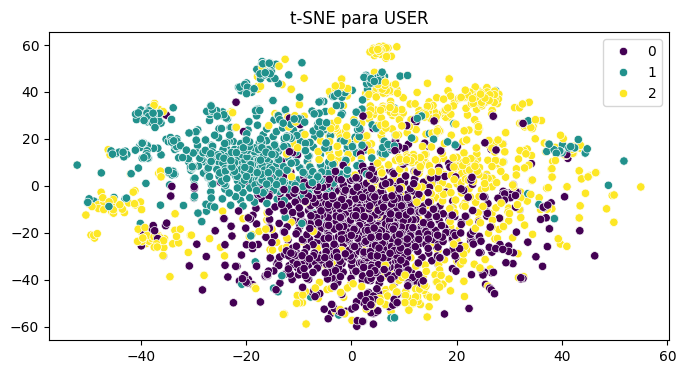

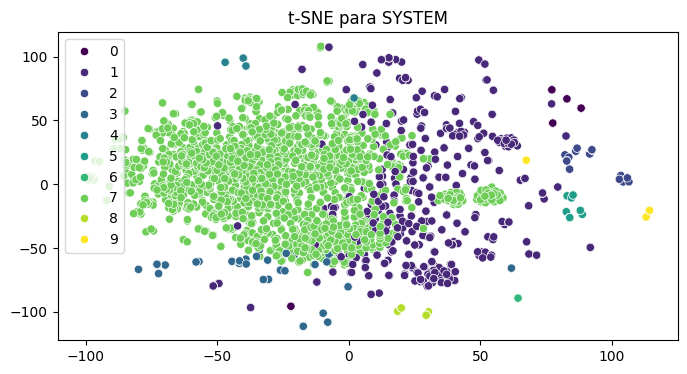

In [ ]:
def apply_tsne(vectors, perplexity=30, n_iter=1000):
    tsne_model = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=2)
    tsne_result = tsne_model.fit_transform(vectors)
    return tsne_result


nomeFichtsneSystem =  f'{MODEL_ML}_{algorithm}_{filename.split(".")[0]}_{metric_to_optimize}_{str(id_max)}_tsne_system.pkl'
nomeFichtsneUser = f'{MODEL_ML}_{algorithm}_{filename.split(".")[0]}_{metric_to_optimize}_{str(id_max)}_tsne_user.pkl'

# Aplicar t-SNE aos vetores
if not os.path.exists(nomeFichtsneSystem) or not os.path.exists(nomeFichtsneUser):
    tsne_result_user = apply_tsne(vectors_user)

    tsne_result_system = apply_tsne(vectors_system)

    with open(nomeFichtsneUser, 'wb') as file:
        pickle.dump(tsne_result_user, file)

    with open(nomeFichtsneSystem, 'wb') as file:
        pickle.dump(tsne_result_system, file)
else:
    with open(nomeFichtsneUser, 'rb') as file:
        tsne_result_user = pickle.load(file)

    with open(nomeFichtsneSystem, 'rb') as file:
        tsne_result_system = pickle.load(file)

# Criar gráfico de dispersão para o utilizador
plt.figure(figsize=(8, 4))
sns.scatterplot(x=tsne_result_user[:, 0], y=tsne_result_user[:, 1], hue=y_predicted_user, palette="viridis", legend="full")
plt.title("t-SNE para USER")
plt.show()

# Criar gráfico de dispersão para o sistema
plt.figure(figsize=(8, 4))
sns.scatterplot(x=tsne_result_system[:, 0], y=tsne_result_system[:, 1], hue=y_predicted_system, palette="viridis", legend="full")
plt.title("t-SNE para SYSTEM")
plt.show()


#### Dados com PCA aplicado

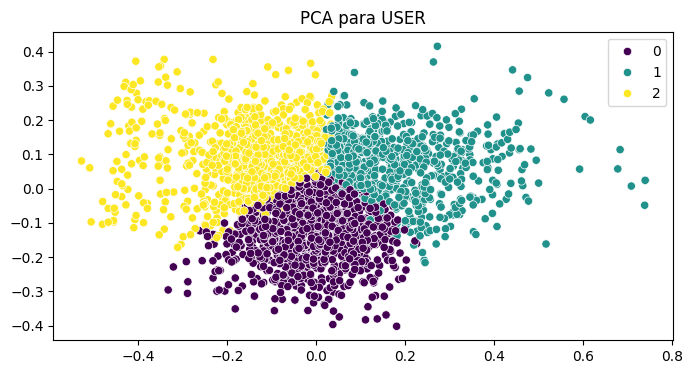

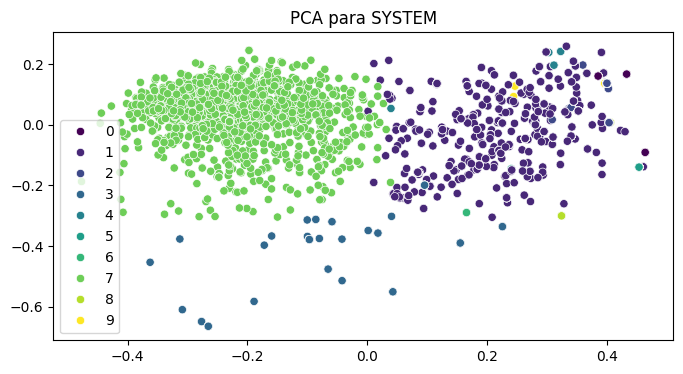

In [ ]:
def apply_pca(vectors, n_components=2):
    pca_model = PCA(n_components=n_components, random_state=2)
    pca_result = pca_model.fit_transform(vectors)
    return pca_result

nomeFichpcaSystem =  f'{MODEL_ML}_{algorithm}_{filename.split(".")[0]}_{metric_to_optimize}_{str(id_max)}_pca_system.pkl'
nomeFichpcaUser = f'{MODEL_ML}_{algorithm}_{filename.split(".")[0]}_{metric_to_optimize}_{str(id_max)}_pca_user.pkl'

# Aplicar PCA aos vetores
if not os.path.exists(nomeFichpcaSystem) or not os.path.exists(nomeFichpcaUser):
    pca_result_user = apply_pca(vectors_user)

    pca_result_system = apply_pca(vectors_system)

    with open(nomeFichpcaUser, 'wb') as file:
        pickle.dump(pca_result_user, file)

    with open(nomeFichpcaSystem, 'wb') as file:
        pickle.dump(pca_result_system, file)
else:
    with open(nomeFichpcaUser, 'rb') as file:
        pca_result_user = pickle.load(file)

    with open(nomeFichpcaSystem, 'rb') as file:
        pca_result_system = pickle.load(file)


# Criar gráfico de dispersão USER
plt.figure(figsize=(8, 4))
sns.scatterplot(x=pca_result_user[:, 0], y=pca_result_user[:, 1], hue=y_predicted_user, palette="viridis", legend="full")
plt.title("PCA para USER")
plt.show()

# Criar gráfico de dispersão SYSTEM
plt.figure(figsize=(8, 4))
sns.scatterplot(x=pca_result_system[:, 0], y=pca_result_system[:, 1], hue=y_predicted_system, palette="viridis", legend="full")
plt.title("PCA para SYSTEM")
plt.show()


## Teste

### Formatação dos dados e vetorização

In [ ]:
#AVALIAÇÃO
if filename[-4:] == ".csv":
  dados_test = pd.read_csv(filename_test, sep=';')
else:
  dados_test = pd.read_excel(filename_test)

normalized_df_test = normalize_dataset(dados_test, regex=True, removeGreetings=False, speaker='both')
normalized_df_user_test = normalized_df_test[normalized_df_test['Speaker'] == 'USER']
normalized_df_system_test = normalized_df_test[normalized_df_test['Speaker'] == 'SYSTEM']


file_path_system = os.path.abspath(nomeFichPickleSystem_silh)
file_path_user = os.path.abspath(nomeFichPickleUser_silh)

# Carregar o modelo
AlgoSystem = joblib.load(file_path_system)
AlgoUser = joblib.load(file_path_user)
print(AlgoSystem)
#USER
model = SentenceTransformer(MODEL_ML)

names_user = names[:n_clusters_user]
utterances_user_test = normalized_df_user_test["utterance"].tolist()
dados_codificados_user_test = model.encode(utterances_user_test)

# Kmeans
y_predicted_user_test = AlgoUser.predict(dados_codificados_user_test)
# DBSCAN
#y_predicted_user_test = dbscan_predict(utterances_user, AlgoUser, dados_codificados_user_test)

if acts:
  df_user_test = normalized_df_user_test[["dialogue_id", "turn_id",'Speaker', "trueLabel"]].copy()
else:
  # Se não houver dialog acts
  df_user_test = normalized_df_user_test[["dialogue_id", "turn_id",'Speaker']].copy()
df_user_test["clusters_user"] = y_predicted_user_test

#SYSTEM
names_system = names[n_clusters_user:-2]
utterances_system_test = normalized_df_system_test["utterance"].tolist()
dados_codificados_system_test = model.encode(utterances_system_test)

# Kmeans
y_predicted_system_test = AlgoSystem.predict(dados_codificados_system_test)
# DBSCAN
#y_predicted_system_test = dbscan_predict(utterances_system, AlgoSystem, dados_codificados_system_test)
if acts:
  df_system_test = normalized_df_system_test[["dialogue_id", "turn_id",'Speaker', "trueLabel"]].copy()
else:
  # Se não houver dialog acts
  df_system_test = normalized_df_system_test[["dialogue_id", "turn_id",'Speaker']].copy()
df_system_test["clusters_system"] = y_predicted_system_test


KMeans(n_clusters=10, n_init=15, random_state=2, tol=0.00016792446116575924)
y_predict_user_test [0 2 2 0 0 0 0 2 1 0 0 2 1 0 2 1 0 1 1 0 1 0 0 2 1 2 2 1 2 0 1 0 2 1 1 2 2
 0 0 2 1 2 2 1 0 2 2 2 1 2 0 0 1 0 0 0 0 1 1 1 2 0 2 0 0 0 1 1 0 1 0 0 0 0
 2 0 1 0 0 2 2 0 2 1 2 0 0 2 2 1 2 0 1 0 1 2 0 1 0 1 1 1 0 0 0 0 0 0 0 2 2
 1 1 2 1 1 1 2 2 0 1 2 0 1 0 1 1 1 1 2 2 2 0 2 0 0 0 1 2 1 0 0 0 0 0 2 2 0
 2 0 2 0 2 2 1 1 1 1 2 1 0 2 1 1 1 1 1 1 2 2 1 0 0 1 0 1 0 0 2 0 1 1 0 1 1
 0 0 2 0 2 0 2 0 1 0 2 1 0 2 2 0 1 2 0 0 1 0 0 0 0 0 2 0 0 0 1 0 2 0 0 0 0
 0 1 0 0 1 0 1 0 1 0 0 0 2 2 0 2 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 2 0 2 1 0 1
 1 1 0 1 1 2 1 1 2 1 0 0 1 0 2 1 1 1 0 1 0 1 2 0 1 1 0 2 0 1 1 1 1 1 0 1 0
 0 2]


In [ ]:
# Final

df_final_test = pd.concat([df_user_test, df_system_test])

df_final_test['clusters_final'] = df_final_test['clusters_user'].fillna(0) + df_final_test['clusters_system'].fillna(0)
df_final_test['sequence'] = range(len(df_final_test))

# Ordena o DataFrame com base na coluna 'sequence'
df_final_test.sort_values(by=['sequence'], inplace=True)

# Remove a coluna 'sequence' após a ordenação, se não for mais necessária
df_final_test.drop(columns=['sequence'], inplace=True)

# Converter a coluna 'n_clusters_final' para o tipo inteiro
df_final_test['clusters_final'] = df_final_test['clusters_final'].astype(int)
# df_final_test.to_csv("df_final_test.csv")

print(names)
print(names_user)
print(names_system)

# df_final_test.to_csv("df_final_test.csv")


['user -> estação queixas xusernamex', 'user -> xusernamex regra segundos', 'user -> stopnato portugalforadanato xusernamex', 'sys -> série vem cabeça', 'sys -> rússia ucrânia xurlx', 'sys -> salas cinema apoio', 'sys -> podes escolher xurlx', 'sys -> aberta combustíveis eletricidade', 'sys -> ansioso ler 2023', 'sys -> sif93 kadjh fhak', 'sys -> situação existe anomalia', 'sys -> bolo rei péssimo', 'sys -> ler outros todos', 'SOD', 'EOD']
['user -> estação queixas xusernamex', 'user -> xusernamex regra segundos', 'user -> stopnato portugalforadanato xusernamex']
['sys -> série vem cabeça', 'sys -> rússia ucrânia xurlx', 'sys -> salas cinema apoio', 'sys -> podes escolher xurlx', 'sys -> aberta combustíveis eletricidade', 'sys -> ansioso ler 2023', 'sys -> sif93 kadjh fhak', 'sys -> situação existe anomalia', 'sys -> bolo rei péssimo', 'sys -> ler outros todos']


### Obter valores de métricas

In [ ]:
for i, t in enumerate(threshold):
    dot_filename = f'{Path(filename).stem}_{algorithm}_{metric_to_optimize}_{str(id_max)}_graph.dot'

    nomeFichParSystem = f'{Path(filename).stem}_{metric_to_optimize}_{algorithm}_{str(id_max)}_param_{t}.txt'

    v_measure_test_user = 0
    v_measure_train_user = 0
    v_measure_test_system = 0
    v_measure_train_system = 0
    v_measure_test = 0
    v_measure_train = 0
    accuracy = 0

    (flow,) = pydot.graph_from_dot_file(dot_filename)

    # matrix.to_csv("matrix.csv")
    accuracy = calcular_accuracy_transicoes(df_final_test, flow, names_user, names_system)
    print("ACCURACY", accuracy)

    df_final_test_clear = df_final_test.copy()

    def modify_value(row):
        if row['Speaker'] == 'SYSTEM':
            return 's' + str(row['clusters_final'])
        elif row['Speaker'] == 'USER':
            return 'u' + str(row['clusters_final'])
        else:
            return row['clusters_final']

    def modify_true_value(row):
        if row['Speaker'] == 'SYSTEM':
            return 's' + str(row['trueLabel'])
        elif row['Speaker'] == 'USER':
            return 'u' + str(row['trueLabel'])
        else:
            return row['trueLabel']

    def modify_train_value(row):
        if row['Speaker'] == 'SYSTEM':
            return 's' + str(row['n_clusters_final'])
        elif row['Speaker'] == 'USER':
            return 'u' + str(row['n_clusters_final'])
        else:
            return row['n_clusters_final']


    # Apply the function to the DataFrame
    df_final_test_clear['clusters_final'] = df_final_test_clear.apply(modify_value, axis=1)
    df_final['n_clusters_final'] = df_final.apply(modify_train_value, axis=1)

    if acts:
        df_final_test_clear['trueLabel'] = df_final_test_clear.apply(modify_true_value, axis=1)
        df_final['trueLabel'] = df_final.apply(modify_true_value, axis=1)

        # User
        v_measure_test_user = metrics.v_measure_score(df_user_test['trueLabel'], df_user_test['clusters_user'], beta = beta)
        v_measure_train_user = metrics.v_measure_score(normalized_df_user['trueLabel'], normalized_df_user['cluster_user'], beta = beta)

        # System
        v_measure_test_system = metrics.v_measure_score(df_system_test['trueLabel'], df_system_test['clusters_system'], beta = beta)
        v_measure_train_system = metrics.v_measure_score(normalized_df_system['trueLabel'], normalized_df_system['cluster_system'], beta = beta)

        # Both
        v_measure_test = metrics.v_measure_score(df_final_test_clear['trueLabel'], df_final_test_clear['clusters_final'], beta = beta)
        v_measure_train = metrics.v_measure_score(df_final['trueLabel'], df_final['n_clusters_final'], beta = beta)

    # z = (x – min(x)) / (max(x) – min(x))
    # Silhouette Score Normalize from [-1:1] to [0:1]
    silhouette_score = (silhouette_system + silhouette_user) / 2
    silhouette_score_norm = (silhouette_score + 1) / 2

    Silhacc = (2 * accuracy * silhouette_score_norm) / (accuracy + silhouette_score_norm)

    # Davies Bouldin Score
    #davies_bouldin_score = (-davies_bouldin_user - davies_bouldin_system) / 2
    #calinski_harabasz_score = (calinski_harabasz_user + calinski_harabasz_system) / 2

    file = open(nomeFichParSystem, 'w')
    print("Clusters User: ", len(np.unique(y_predicted_user[y_predicted_user != -1])), file=file)
    print("Clusters System: ", len(np.unique(y_predicted_system[y_predicted_system != -1])), file=file)
    print("\nAccuracy: ", accuracy, file=file)
    print("\nV-measure Teste User: ", v_measure_test_user, file=file)
    print("\nV-measure Treino User: ", v_measure_train_user, file=file)
    print("\nV-measure Teste System: ", v_measure_test_system, file=file)
    print("\nV-measure Treino System: ", v_measure_train_system, file=file)
    print("\nV-measure Teste: ", v_measure_test, file=file)
    print("\nV-measure Treino: ", v_measure_train, file=file)
    #print("\nSilhouette System: ", silhouette_system, file=file)
    #print("Silhouette User: ", silhouette_user, file=file)
    #print("Silhouette: ", silhouette_score, file=file)
    #print("Davies Bouldin Score: ", davies_bouldin_score, file=file)
    #print("Calinski and Harabasz Score: ", calinski_harabasz_score, file=file)
    #print("\nResult: ", result[i], file=file)
    print("Silhacc: ", Silhacc, file=file)

    file.close()


num_dialogos 258
num_utterances 590
258 330 258
ACCURACY 0.9976415094339622
